# STEP 1: FIND NEAR-OPTIMAL PATHS (Nearest Shortest Paths)

In [ ]:
import heapq
import time
import copy
from collections import defaultdict
import pulp
import matplotlib.pyplot as plt
import networkx as nx

# ================================
# STEP 1: BUILD THE EXPANDED GRAPH
# ================================

def build_expanded_graph(n_physical, edges):
    G_exp = defaultdict(list)
    for u, v, mode, length in edges:
        if mode == 1:  # Road
            G_exp[(u, 1)].append(((v, 1), length))        # Road → Road
            G_exp[(u, 1)].append(((v, 2), length + 2))    # Road → Water (switch cost = 2)
        elif mode == 2:  # Water
            G_exp[(u, 2)].append(((v, 2), length))        # Water → Water
            G_exp[(u, 2)].append(((v, 1), length + 2))    # Water → Road
    return G_exp

# ================================
# STEP 2: DIJKSTRA FROM MULTIPLE TARGETS
# ================================

def dijkstra_multi_target(G_exp_rev, targets):
    dist = defaultdict(lambda: float('inf'))
    heap = []
    for target in targets:
        dist[target] = 0
        heapq.heappush(heap, (0, target))
    while heap:
        d, node = heapq.heappop(heap)
        if d > dist[node]: continue
        for neighbor, length in G_exp_rev.get(node, []):
            new_d = d + length
            if new_d < dist[neighbor]:
                dist[neighbor] = new_d
                heapq.heappush(heap, (new_d, neighbor))
    return dist

# ================================
# STEP 3: FIND NEAR-OPTIMAL PATHS
# ================================

def find_near_optimal_paths(G_exp, n_physical, s, t, epsilon, d_prime, Lmin):
    results = []
    for start_mode in [1, 2]:
        visited = [False] * n_physical
        visited[s] = True
        stack = [((s, start_mode), 0, [], visited[:])]
        while stack:
            node, cost, path, visited = stack.pop()
            u, mode = node
            if u == t:
                results.append((path + [node], cost))
                continue
            for (v, vmode), length in G_exp.get(node, []):
                if visited[v]: continue
                new_cost = cost + length
                if new_cost + d_prime.get((v, vmode), float('inf')) > (1 + epsilon) * Lmin:
                    continue
                new_visited = visited[:]
                new_visited[v] = True
                stack.append(((v, vmode), new_cost, path + [node], new_visited))
    return results

# STEP 2: INPUT DATA FROM THE TOY EXAMPLE

In [ ]:
# ================================
# TOY EXAMPLE DATA
# ================================

n_physical = 6  # 0-indexed: 0=AnGiang, 1=DongThap, 2=CanTho, 3=HCM, 4=VinhLong
s_list = [0, 1, 1]  # origins
t_list = [3, 4, 3]  # destinations
od_pairs = [('g1', (0,3)), ('g1', (1,4)), ('g2', (1,3))]  # (commodity, (o,d))

# Edges (u, v, mode, cost): mode 1=road, 2=water
edges = [
    (0, 2, 1, 5), (0, 2, 2, 3),  # AnGiang → CanTho
    (1, 2, 1, 4), (1, 2, 2, 2),  # DongThap → CanTho
    (2, 3, 1, 6), (2, 3, 2, 3),  # CanTho → HCM
    (2, 4, 1, 5), (2, 4, 2, 2),  # CanTho → VinhLong
]

# Build expanded graph
G_exp = build_expanded_graph(n_physical, edges)

# Reverse graph to run Dijkstra from the destinations
G_exp_rev = defaultdict(list)
for u in G_exp:
    for v, w in G_exp[u]:
        G_exp_rev[v].append((u, w))

# Compute Lmin for each O-D pair
Lmin_dict = {}
d_prime_dict = {}
for s, t in zip(s_list, t_list):
    targets = [(t, 1), (t, 2)]
    d_prime = dijkstra_multi_target(G_exp_rev, targets)
    Lmin = min(d_prime.get((s,1), float('inf')), d_prime.get((s,2), float('inf')))
    Lmin_dict[(s,t)] = Lmin
    d_prime_dict[(s,t)] = d_prime

# STEP 3: FIND ALL NEAR-OPTIMAL PATHS (ε = 0.5)

In [ ]:
epsilon = 0.5
paths_found = {}

print("FIND NEAR-OPTIMAL PATHS (ε = 0.5)\n" + "="*50)
for idx, (g, (o, d)) in enumerate(od_pairs):
    s, t = o, d
    Lmin = Lmin_dict[(s,t)]
    d_prime = d_prime_dict[(s,t)]
    print(f"\nO-D: {o}→{d} | Lmin = {Lmin}")
    near_paths = find_near_optimal_paths(G_exp, n_physical, s, t, epsilon, d_prime, Lmin)
    print(f"   → Found {len(near_paths)} path(s)")
    paths_found[(g, (o,d))] = near_paths

FIND NEAR-OPTIMAL PATHS (ε = 0.5)

O-D: 0→3 | Lmin = 6
   → Found 2 path(s)

O-D: 1→4 | Lmin = 4
   → Found 2 path(s)

O-D: 1→3 | Lmin = 5
   → Found 2 path(s)


# STEP 4: CONVERT PATHS → VIRTUAL ARCS (used in PuLP)

In [ ]:
# Create virtual nodes: 3^1, 3^2, 4^1, 4^2, 5^1, 5^2
virtual_map = {3: ['3^1','3^2'], 4: ['4^1','4^2'], 5: ['5^1','5^2']}
real_nodes = [0,1,2,3,4]
all_nodes = real_nodes + [v for vals in virtual_map.values() for v in vals]

# Convert physical path → path with virtual arcs
def convert_to_virtual_path(phys_path):
    vpath = []
    for i in range(len(phys_path)-1):
        u_node = phys_path[i]
        v_node = phys_path[i+1]
        u, umode = u_node
        v, vmode = v_node
        # From real u → virtual v
        if u in virtual_map:
            virt_u = virtual_map[u][umode-1]
            vpath.append((u, virt_u))
        else:
            vpath.append((u, f"{v}^{vmode}"))
        # From virtual → real v
        if v in virtual_map:
            virt_v = virtual_map[v][vmode-1]
            vpath.append((virt_v, v))
    return vpath

# Generate paths for PuLP
paths_pulp = {}
for (g, od), phys_paths in paths_found.items():
    pulp_paths = []
    for path_nodes, cost in phys_paths:
        virtual_path = convert_to_virtual_path(path_nodes)
        pulp_paths.append(virtual_path)
    paths_pulp[(g, od)] = pulp_paths

# STEP 5: RUN THE PULP OPTIMIZATION MODEL

In [ ]:
# ================================
# PULP MODEL SETUP
# ================================

T = [1, 2]
H = [2]  # Can Tho
potential_hubs = [2]
potential_arcs = [(2, '3^1'), (2, '3^2')]  # CanTho → HCM (road/water)
existing_arcs = [(0,'3^1'),(0,'3^2'),(1,'3^1'),(1,'3^2'),(2,'4^1'),(2,'4^2')]

# Costs
hub_upgrade_cost = 1000
hub_capacity = {0: 2000, 1: 7000}
arc_upgrade_costs = {(2,'3^1'): 800, (2,'3^2'): 500}
arc_capacities = {(2,'3^1'): {0:0, 1:3000}, (2,'3^2'): {0:0, 1:4000}}
existing_arc_capacity = 2000
switch_cost = 2
hub_service_cost = {2: 1}

# Transportation cost on real arcs
arc_costs = {
    (0,'3^1'):5, (0,'3^2'):3,
    (1,'3^1'):4, (1,'3^2'):2,
    (2,'3^1'):6, (2,'3^2'):3,
    (2,'4^1'):5, (2,'4^2'):2,
}
for a in [(v, real) for real in [3,4] for v in virtual_map.get(real,[])]:
    arc_costs[a] = 0  # virtual → real

# Demand
demands = {('g1',(0,3)):1000, ('g1',(1,4)):800, ('g2',(1,3)):2000}

# Create model
model = pulp.LpProblem("Mekong_Toy_Optimization", pulp.LpMinimize)

# Variables
y_hub = pulp.LpVariable.dicts("y_hub", [(h,l,t) for h in potential_hubs for l in [0,1] for t in T], cat='Binary')
y_arc = pulp.LpVariable.dicts("y_arc", [(a[0],a[1],l,t) for a in potential_arcs for l in [0,1] for t in T], cat='Binary')
v_path = {}
for (g,od), path_list in paths_pulp.items():
    for idx in range(len(path_list)):
        for t in T:
            v_path[(g,od,idx,t)] = pulp.LpVariable(f"v_{g}_{od[0]}_{od[1]}_p{idx}_t{t}", 0, 1)
u_hub = pulp.LpVariable.dicts("u_hub", [(h,t) for h in H for t in T], lowBound=0)
x_arc = pulp.LpVariable.dicts("x_arc", [(a[0],a[1],t) for a in existing_arcs + potential_arcs for t in T], lowBound=0)

# Path cost function
def get_path_cost(path):
    cost = 0
    switches = 0
    prev_mode = None
    for arc in path:
        cost += arc_costs.get(arc, 0)
        mode = 1 if '^1' in str(arc[1]) else 2
        if prev_mode and prev_mode != mode:
            switches += 1
        prev_mode = mode
    return cost + switches * switch_cost

# Objective
obj = pulp.lpSum(hub_upgrade_cost * hub_capacity[l] * y_hub[(h,l,t)] 
                 for h in potential_hubs for l in [0,1] for t in T)
obj += pulp.lpSum(arc_upgrade_costs[a] * arc_capacities[a][l] * y_arc[(a[0],a[1],l,t)]
                  for a in potential_arcs for l in [0,1] for t in T)
obj += pulp.lpSum(hub_service_cost[h] * u_hub[(h,t)] for h in H for t in T)
for (g,od), path_list in paths_pulp.items():
    demand = demands[(g,od)]
    for idx, path in enumerate(path_list):
        path_cost = get_path_cost(path)
        for t in T:
            obj += path_cost * demand * v_path[(g,od,idx,t)]
model += obj

# Constraints
for (g,od) in demands:
    for t in T:
        model += pulp.lpSum(v_path[(g,od,idx,t)] for idx in range(len(paths_pulp[(g,od)]))) == 1

for h in H:
    for t in T:
        flow = pulp.lpSum(demands[(g,od)] * v_path[(g,od,idx,t)]
                          for (g,od) in demands
                          for idx, path in enumerate(paths_pulp[(g,od)])
                          if any(a[1] in ['3^1','3^2'] or a[0] in ['3^1','3^2'] for a in path))
        model += u_hub[(h,t)] == flow

for a in existing_arcs + potential_arcs:
    for t in T:
        flow = pulp.lpSum(demands[(g,od)] * v_path[(g,od,idx,t)]
                          for (g,od) in demands
                          for idx, path in enumerate(paths_pulp[(g,od)])
                          if a in path)
        model += x_arc[(a[0],a[1],t)] == flow

# Capacity
for h in potential_hubs:
    for t in T:
        model += u_hub[(h,t)] <= pulp.lpSum(hub_capacity[l] * y_hub[(h,l,t)] for l in [0,1])
for a in potential_arcs:
    for t in T:
        model += x_arc[(a[0],a[1],t)] <= pulp.lpSum(arc_capacities[a][l] * y_arc[(a[0],a[1],l,t)] for l in [0,1])
for a in existing_arcs:
    if a in [(0,'3^1'),(0,'3^2'),(1,'3^1'),(1,'3^2'),(2,'4^1'),(2,'4^2')]:
        for t in T:
            model += x_arc[(a[0],a[1],t)] <= existing_arc_capacity

# Logic
for h in potential_hubs:
    for t in T:
        model += pulp.lpSum(y_hub[(h,l,t)] for l in [0,1]) == 1
for a in potential_arcs:
    for t in T:
        model += pulp.lpSum(y_arc[(a[0],a[1],l,t)] for l in [0,1]) == 1

# Non-decreasing
for h in potential_hubs:
    model += pulp.lpSum(hub_capacity[l] * y_hub[(h,l,2)] for l in [0,1]) >= \
             pulp.lpSum(hub_capacity[l] * y_hub[(h,l,1)] for l in [0,1])
for a in potential_arcs:
    model += pulp.lpSum(arc_capacities[a][l] * y_arc[(a[0],a[1],l,2)] for l in [0,1]) >= \
             pulp.lpSum(arc_capacities[a][l] * y_arc[(a[0],a[1],l,1)] for l in [0,1])

# Solve
model.solve(pulp.PULP_CBC_CMD(msg=1))
print(f"\nOPTIMAL: {pulp.LpStatus[model.status]} | Total cost: {pulp.value(model.objective):,.0f}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/dinhxuantruong/2022/Jupyter/test_env/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/h4/zst5rtt5313_x9ycg4yt3ymr0000gn/T/9f7c8b6a65134814b43c5f0620558eea-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/h4/zst5rtt5313_x9ycg4yt3ymr0000gn/T/9f7c8b6a65134814b43c5f0620558eea-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 56 COLUMNS
At line 199 RHS
At line 251 BOUNDS
At line 276 ENDATA
Problem MODEL has 51 rows, 42 columns and 96 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.0272e+06 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0004I processed model has 6 rows, 8 columns (4 integer (4 of which binary)) and 16 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 2.22

# OUTPUT RESULTS

In [ ]:
# Print investment results
print("\n" + "="*60)
print("INVESTMENT & TRANSPORT PLAN")
print("="*60)

prov = {0:"An Giang", 1:"Dong Thap", 2:"Can Tho", 3:"Ho Chi Minh City", 4:"Vinh Long"}

# Hub
print("\n[1] HUB UPGRADES:")
for h in potential_hubs:
    up1 = pulp.value(y_hub[(h,1,1)])
    up2 = pulp.value(y_hub[(h,1,2)])
    print(f"   Can Tho: Period 1={'Upgrade' if up1>0.5 else 'No'}, Period 2={'Maintain' if up2>0.5 and up1>0.5 else 'Upgrade' if up2>0.5 else 'No'}")

# Arc
print("\n[2] ROUTE UPGRADES:")
for a in potential_arcs:
    mode = "ROAD" if '^1' in a[1] else "WATERWAY"
    up1 = pulp.value(y_arc[(a[0],a[1],1,1)])
    print(f"   {prov[a[0]]}→Ho Chi Minh City ({mode}): Period 1={'Upgrade' if up1>0.5 else 'No'}")

# Flow allocation
print("\n[3] FREIGHT ALLOCATION:")
for (g,od), path_list in paths_pulp.items():
    print(f"\n   {g.upper()}: {prov[od[0]]} → {prov[od[1]]}")
    for t in T:
        print(f"   • Period {t}:")
        for idx, path in enumerate(path_list):
            flow = demands[(g,od)] * pulp.value(v_path[(g,od,idx,t)])
            if flow > 1:
                desc = " → ".join([f"{prov.get(a[0],a[0])}" if isinstance(a[0],int) else a[0].split('^')[0] for a in path])
                print(f"     Path {idx+1}: {flow:,.0f} units")


INVESTMENT & TRANSPORT PLAN

[1] UPGRADE HUB:
   Can Tho: Period 1=Upgrade, Period 2=Maintain

[2] UPGRADE ROUTES:
   Can Tho→Ho Chi Minh City (ROAD): Period 1=None
   Can Tho→Ho Chi Minh City (WATERWAY): Period 1=Upgrade

[3] FLOW ALLOCATION:

   G1: An Giang → Ho Chi Minh City
   • Period 1:
     Path 2: 1,000 units
   • Period 2:
     Path 2: 1,000 units

   G1: Dong Thap → Vinh Long
   • Period 1:
     Path 2: 800 units
   • Period 2:
     Path 2: 800 units

   G2: Dong Thap → Ho Chi Minh City
   • Period 1:
     Path 2: 2,000 units
   • Period 2:
     Path 2: 2,000 units


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import numpy as np

def visualize_network_with_upgrades(G_before, G_after, shortest_path, near_paths, upgrades_arcs, upgrades_hubs, period):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    pos = nx.spring_layout(G_before, seed=42, k=0.3)
    
    # --- Before upgrade ---
    nx.draw_networkx_nodes(G_before, pos, ax=ax1, node_color='lightgray', node_size=300)
    nx.draw_networkx_edges(G_before, pos, ax=ax1, edge_color='gray', width=1, alpha=0.6)
    nx.draw_networkx_labels(G_before, pos, ax=ax1, font_size=8)
    ax1.set_title(f"Period {period}: Before Upgrade", fontsize=12, pad=20)

    # Shortest path
    path_edges = list(zip(shortest_path, shortest_path[1:]))
    nx.draw_networkx_edges(G_before, pos, edgelist=path_edges, ax=ax1,
                           edge_color='red', width=4, style='-', label='Shortest Path')

    # Near-optimal paths
    colors = plt.cm.Blues(np.linspace(0.4, 1, len(near_paths)))
    for i, path in enumerate(near_paths):
        path_edges_near = list(zip(path, path[1:]))
        nx.draw_networkx_edges(G_before, pos, edgelist=path_edges_near, ax=ax1,
                               edge_color=colors[i], width=2, style='--', alpha=0.7)

    # --- After upgrade ---
    nx.draw_networkx_nodes(G_after, pos, ax=ax2, node_color='lightgray', node_size=300)
    nx.draw_networkx_edges(G_after, pos, ax=ax2, edge_color='gray', width=1, alpha=0.6)
    
    # Upgraded route (orange border)
    for (u, v) in upgrades_arcs:
        x = [pos[u][0], pos[v][0]]
        y = [pos[u][1], pos[v][1]]
        ax2.plot(x, y, color='orange', linewidth=5, alpha=0.8, zorder=1)
        ax2.arrow(x[0], y[0], x[1]-x[0], y[1]-y[0], width=0.001, head_width=0.03,
                  head_length=0.03, fc='orange', ec='orange', length_includes_head=True)

    # Upgraded hub
    for hub in upgrades_hubs:
        x, y = pos[hub]
        bbox = FancyBboxPatch((x-0.05, y-0.05), 0.1, 0.1, boxstyle="round,pad=0.02",
                              fc='yellow', ec='red', lw=2, alpha=0.8, zorder=10)
        ax2.add_patch(bbox)
        ax2.text(x, y, f"L{upgrades_hubs[hub]}", ha='center', va='center', fontsize=9, fontweight='bold')

    # Shortest path after the upgrade
    nx.draw_networkx_edges(G_after, pos, edgelist=path_edges, ax=ax2,
                           edge_color='darkred', width=4, style='-', label='New Shortest Path')

    nx.draw_networkx_labels(G_after, pos, ax=ax2, font_size=8)
    ax2.set_title(f"Period {period}: After Upgrade", fontsize=12, pad=20)

    plt.suptitle("Shortest vs Near-Optimal Paths & Infrastructure Upgrades", fontsize=16, y=0.95)
    ax1.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Example usage
# G_before, G_after, shortest_path, near_paths, upgrades_arcs, upgrades_hubs = ...
# visualize_network_with_upgrades(G_before, G_after, shortest_path, near_paths, upgrades_arcs, upgrades_hubs, period=2)

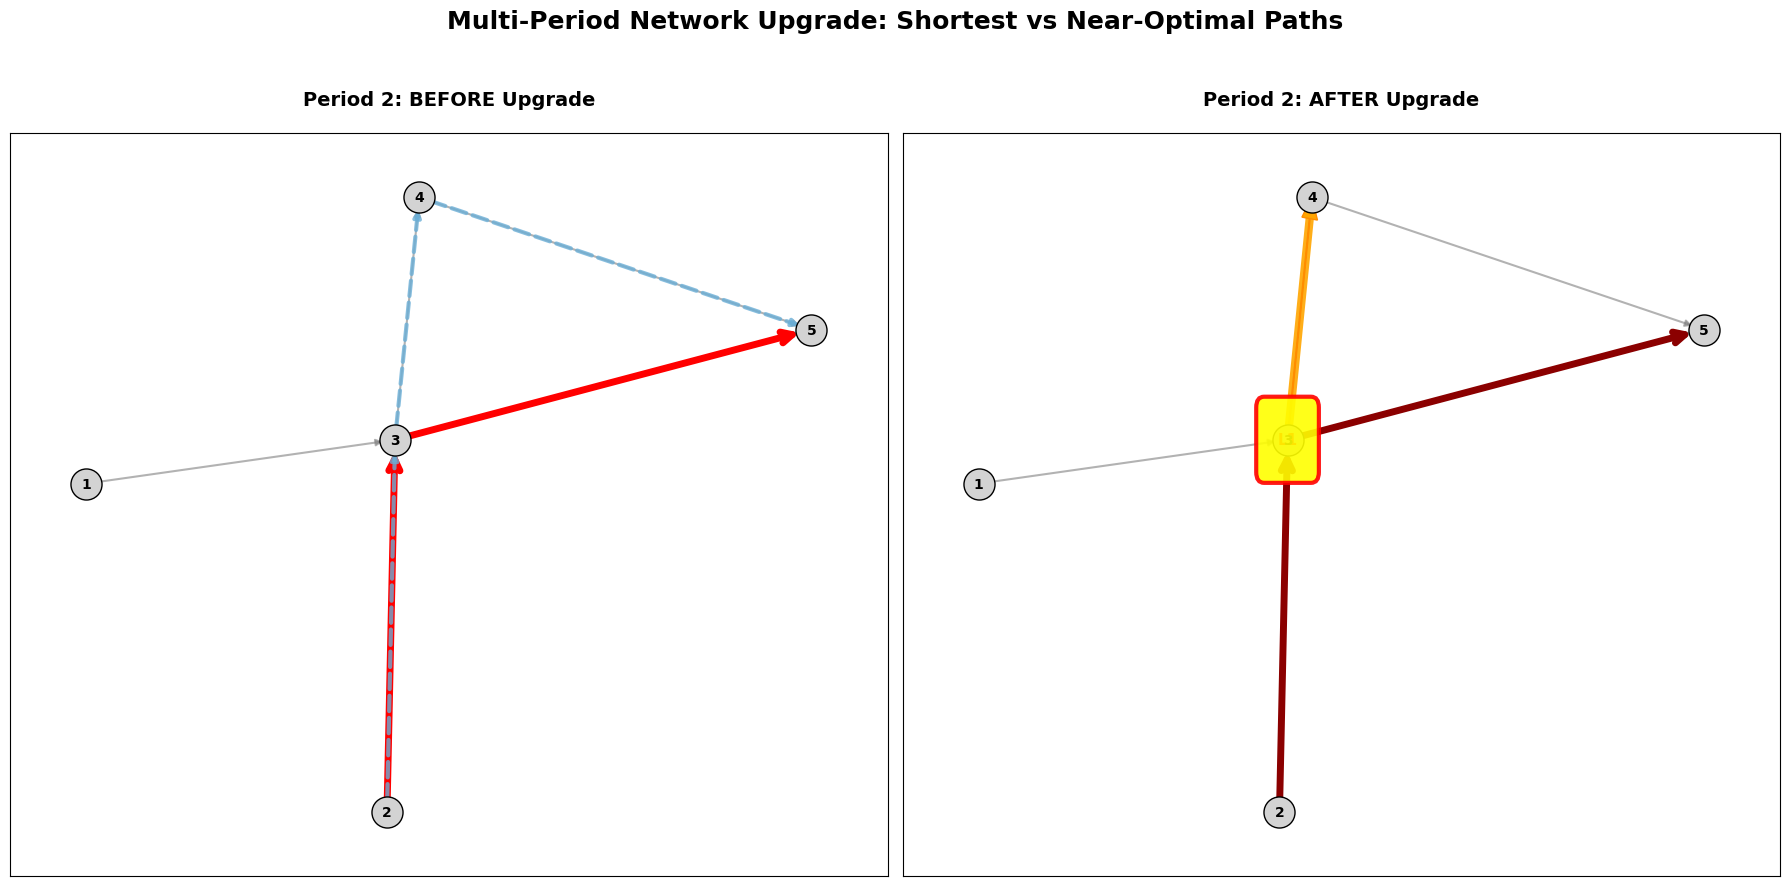

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import numpy as np

# === 1. Visualization function (existing) ===
def visualize_network_with_upgrades(G_before, G_after, shortest_path, near_paths, upgrades_arcs, upgrades_hubs, period):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
    pos = nx.spring_layout(G_before, seed=42, k=0.35)

    # --- Before upgrade ---
    nx.draw_networkx_nodes(G_before, pos, ax=ax1, node_color='lightgray', node_size=500, edgecolors='black')
    nx.draw_networkx_edges(G_before, pos, ax=ax1, edge_color='gray', width=1.5, alpha=0.6, arrows=True)
    nx.draw_networkx_labels(G_before, pos, ax=ax1, font_size=10, font_weight='bold')

    # Shortest path (bold red)
    path_edges = list(zip(shortest_path, shortest_path[1:]))
    nx.draw_networkx_edges(G_before, pos, edgelist=path_edges, ax=ax1,
                           edge_color='red', width=5, style='-', arrowstyle='->', arrowsize=20)

    # Near-optimal paths (blue, decreasing thickness)
    colors = plt.cm.Blues(np.linspace(0.5, 1, len(near_paths)))
    for i, path in enumerate(near_paths):
        path_edges_near = list(zip(path, path[1:]))
        nx.draw_networkx_edges(G_before, pos, edgelist=path_edges_near, ax=ax1,
                               edge_color=colors[i], width=3-i*0.5, style='--', alpha=0.8)

    ax1.set_title(f"Period {period}: BEFORE Upgrade", fontsize=14, fontweight='bold', pad=20)

    # --- After upgrade ---
    nx.draw_networkx_nodes(G_after, pos, ax=ax2, node_color='lightgray', node_size=500, edgecolors='black')
    nx.draw_networkx_edges(G_after, pos, ax=ax2, edge_color='gray', width=1.5, alpha=0.6, arrows=True)

    # Upgraded edges (orange border + arrow)
    for (u, v) in upgrades_arcs:
        x = [pos[u][0], pos[v][0]]
        y = [pos[u][1], pos[v][1]]
        ax2.plot(x, y, color='orange', linewidth=6, alpha=0.9, zorder=1)
        ax2.arrow(x[0], y[0], x[1]-x[0], y[1]-y[0], width=0.0015, head_width=0.04,
                  head_length=0.04, fc='orange', ec='darkorange', length_includes_head=True)

    # Upgraded hub (yellow square + level label)
    for hub, level in upgrades_hubs.items():
        x, y = pos[hub]
        bbox = FancyBboxPatch((x-0.06, y-0.06), 0.12, 0.12, boxstyle="round,pad=0.02",
                              fc='yellow', ec='red', lw=3, alpha=0.9, zorder=10)
        ax2.add_patch(bbox)
        ax2.text(x, y, f"L{level}", ha='center', va='center', fontsize=11, fontweight='bold', color='red')

    # New shortest path (dark red)
    nx.draw_networkx_edges(G_after, pos, edgelist=path_edges, ax=ax2,
                           edge_color='darkred', width=5, style='-', arrowstyle='->', arrowsize=20)

    nx.draw_networkx_labels(G_after, pos, ax=ax2, font_size=10, font_weight='bold')
    ax2.set_title(f"Period {period}: AFTER Upgrade", fontsize=14, fontweight='bold', pad=20)

    plt.suptitle("Multi-Period Network Upgrade: Shortest vs Near-Optimal Paths", fontsize=18, y=0.98, fontweight='bold')
    fig.patch.set_facecolor('white')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# === 2. Create sample data (based on the Toy Example in the document) ===
G_before = nx.DiGraph()

# Nodes: 1=An Giang, 2=Dong Thap, 3=Can Tho (Hub), 4=Ho Chi Minh City, 5=Vinh Long
nodes = [1, 2, 3, 4, 5]
G_before.add_nodes_from(nodes)

# Arcs with costs (road=high, water=low)
arcs_before = [
    (1, 3, {'cost': 5, 'mode': 'road', 'cap': 1000}),
    (2, 3, {'cost': 6, 'mode': 'road', 'cap': 1000}),
    (3, 4, {'cost': 4, 'mode': 'road', 'cap': 1000}),
    (3, 5, {'cost': 3, 'mode': 'water', 'cap': 2000}),
    (4, 5, {'cost': 2, 'mode': 'road', 'cap': 1000}),
]
G_before.add_edges_from([(u, v, d) for u, v, d in arcs_before])

# Find the shortest path (rice: 2 → 5)
shortest_path = nx.shortest_path(G_before, source=2, target=5, weight='cost')  # [2, 3, 5]

# Find near-optimal paths (ε = 1.5 → cost ≤ 6 + 1.5 = 7.5)
L_min = nx.shortest_path_length(G_before, 2, 5, weight='cost')  # 6 + 3 = 9
near_paths = []
for path in nx.all_simple_paths(G_before, 2, 5, cutoff=5):
    cost = sum(G_before.edges[u,v]['cost'] for u,v in zip(path, path[1:]))
    if cost <= L_min * 1.5:
        if path != shortest_path:
            near_paths.append(path)

# === 3. Simulate upgrades for period 2 ===
G_after = G_before.copy()

# Upgrade arc (3,4): increase capacity + reduce cost
G_after.edges[3,4]['cap'] = 4000
G_after.edges[3,4]['cost'] = 3  # decrease from 4 → 3

# Upgrade hub 3 → level 1
upgrades_hubs = {3: 1}

# Upgrade arc (3,4)
upgrades_arcs = [(3, 4)]

# New shortest path: may use (2→3→4→5) if the cost is better
new_shortest = nx.shortest_path(G_after, 2, 5, weight='cost')  # remains [2,3,5] because 6+3=9 < 6+3+2=11

# === 4. CALL THE VISUALIZATION FUNCTION ===
visualize_network_with_upgrades(
    G_before=G_before,
    G_after=G_after,
    shortest_path=shortest_path,
    near_paths=near_paths,
    upgrades_arcs=upgrades_arcs,
    upgrades_hubs=upgrades_hubs,
    period=2
)

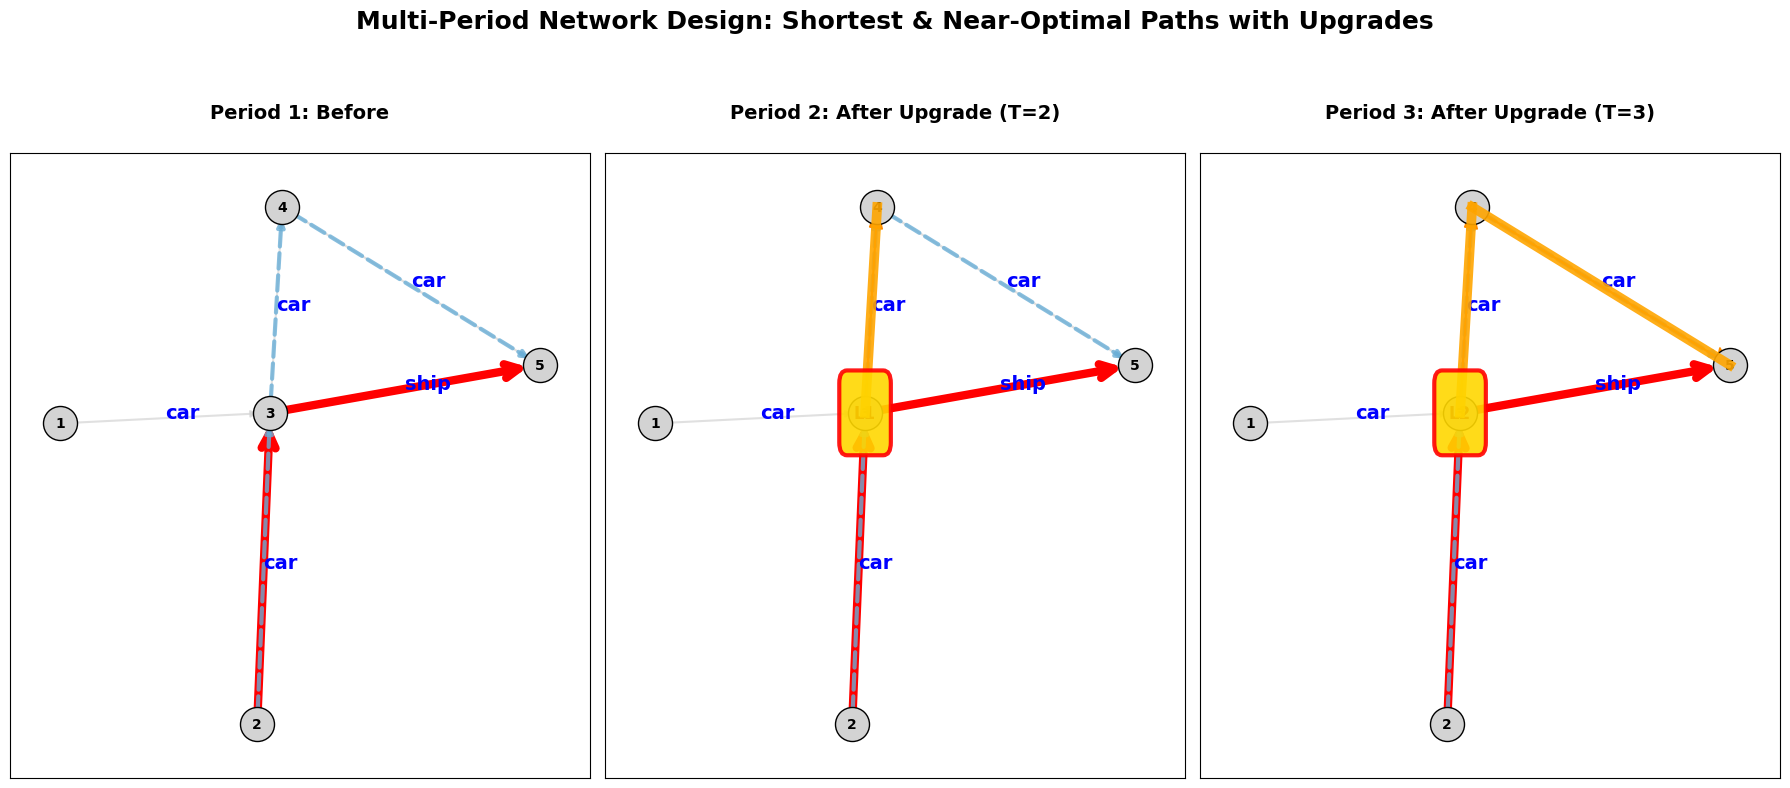

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import numpy as np

# ================================
# 1. UPGRADE VISUALIZATION FUNCTION
# ================================
def visualize_multiperiod_upgrades(G_list, shortest_paths, near_paths_list, upgrades_arcs_list, upgrades_hubs_list, periods=[1,2,3]):
    """
    Draw three parallel charts: before, period 2, period 3
    G_list: [G_t1, G_t2, G_t3]
    shortest_paths: [path_t1, path_t2, path_t3]
    near_paths_list: [[], [near_t2], [near_t3]]
    upgrades_arcs_list: [[], [(3,4)], [(3,4),(6,7)]]
    upgrades_hubs_list: [{}, {3:1}, {3:2}]
    """
    n_periods = len(periods)
    fig, axes = plt.subplots(1, n_periods, figsize=(6*n_periods, 8))
    if n_periods == 1:
        axes = [axes]
    
    # Fixed layout
    pos = nx.spring_layout(G_list[0], seed=42, k=0.4)

    for t_idx, t in enumerate(periods):
        ax = axes[t_idx]
        G = G_list[t_idx]
        shortest_path = shortest_paths[t_idx]
        near_paths = near_paths_list[t_idx]
        upgrades_arcs = upgrades_arcs_list[t_idx]
        upgrades_hubs = upgrades_hubs_list[t_idx]

        # Nodes & base edges
        nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightgray', node_size=600, edgecolors='black')
        nx.draw_networkx_edges(G, pos, ax=ax, edge_color='lightgray', width=1.5, alpha=0.7, arrows=True)
        nx.draw_networkx_labels(G, pos, ax=ax, font_size=10, font_weight='bold')

        # Shortest path: dark red
        if shortest_path:
            path_edges = list(zip(shortest_path, shortest_path[1:]))
            nx.draw_networkx_edges(G, pos, edgelist=path_edges, ax=ax,
                                   edge_color='red', width=6, style='-', arrowstyle='->', arrowsize=25)

        # Near-optimal paths: blue, dashed, decreasing thickness
        if near_paths:
            colors = plt.cm.Blues(np.linspace(0.5, 0.9, len(near_paths)))
            for i, path in enumerate(near_paths):
                path_edges = list(zip(path, path[1:]))
                nx.draw_networkx_edges(G, pos, edgelist=path_edges, ax=ax,
                                       edge_color=colors[i], width=3-i*0.6, style='--', alpha=0.8)

        # Upgraded arcs: orange border + arrow
        for (u, v) in upgrades_arcs:
            x = [pos[u][0], pos[v][0]]
            y = [pos[u][1], pos[v][1]]
            ax.plot(x, y, color='orange', linewidth=7, alpha=0.9, zorder=5)
            ax.arrow(x[0], y[0], x[1]-x[0], y[1]-y[0], width=0.0018, head_width=0.05,
                     head_length=0.05, fc='darkorange', ec='darkorange', length_includes_head=True)

        # Upgraded hub: yellow square + level
        for hub, level in upgrades_hubs.items():
            x, y = pos[hub]
            bbox = FancyBboxPatch((x-0.07, y-0.07), 0.14, 0.14, boxstyle="round,pad=0.03",
                                  fc='gold', ec='red', lw=3, alpha=0.9, zorder=10)
            ax.add_patch(bbox)
            ax.text(x, y, f"L{level}", ha='center', va='center', fontsize=12, fontweight='bold', color='darkred')

        # Mode icons (if present)
        mode_icons = {1: 'car', 2: 'ship', 3: 'truck', 4: 'train'}
        for u, v, d in G.edges(data=True):
            if 'mode' in d:
                mid_x = (pos[u][0] + pos[v][0]) / 2
                mid_y = (pos[u][1] + pos[v][1]) / 2
                icon = mode_icons.get(d['mode'], '?')
                ax.text(mid_x, mid_y, icon, fontsize=14, fontweight='bold', color='blue')

        ax.set_title(f"Period {t}: {'Before' if t==1 else f'After Upgrade (T={t})'}", 
                     fontsize=14, fontweight='bold', pad=25)

    plt.suptitle("Multi-Period Network Design: Shortest & Near-Optimal Paths with Upgrades", 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


# ================================
# 2. TOY EXAMPLE DATA (Figure 4)
# ================================
def create_toy_network():
    G = nx.DiGraph()
    nodes = [1, 2, 3, 4, 5]
    G.add_nodes_from(nodes)

    # Arcs: (u, v, cost, mode, cap)
    arcs = [
        (1, 3, 5, 1, 1000),  # An Giang → Can Tho (road)
        (2, 3, 6, 1, 1000),  # Dong Thap → Can Tho (road)
        (3, 4, 4, 1, 1000),  # Can Tho → Ho Chi Minh City (road)
        (3, 5, 3, 2, 2000),  # Can Tho → Vinh Long (water)
        (4, 5, 2, 1, 1000),  # Ho Chi Minh City → Vinh Long (road)
    ]
    for u, v, c, m, cap in arcs:
        G.add_edge(u, v, cost=c, mode=m, cap=cap)
    return G

# Find near-optimal paths (ε = 1.5)
def find_near_optimal_paths(G, source, target, epsilon=1.5, max_paths=5):
    L_min = nx.shortest_path_length(G, source, target, weight='cost')
    paths = []
    for path in nx.all_simple_paths(G, source, target, cutoff=6):
        cost = sum(G.edges[u,v]['cost'] for u,v in zip(path, path[1:]))
        if L_min <= cost <= L_min * epsilon:
            paths.append((path, cost))
    paths.sort(key=lambda x: x[1])
    return [p[0] for p in paths[:max_paths] if p[0] != nx.shortest_path(G, source, target, weight='cost')]

# ================================
# 3. SIMULATE UPGRADES OVER 3 PERIODS
# ================================
G_base = create_toy_network()

# Period 1: No upgrade
G_t1 = G_base.copy()
shortest_t1 = nx.shortest_path(G_t1, 2, 5, weight='cost')  # [2,3,5]
near_t1 = find_near_optimal_paths(G_t1, 2, 5)

# Period 2: Upgrade arc (3,4), hub 3 → L1
G_t2 = G_t1.copy()
G_t2.edges[3,4]['cost'] = 3
G_t2.edges[3,4]['cap'] = 4000
shortest_t2 = nx.shortest_path(G_t2, 2, 5, weight='cost')  # still [2,3,5]
near_t2 = find_near_optimal_paths(G_t2, 2, 5)

# Period 3: Upgrade arc (4,5), hub 3 → L2
G_t3 = G_t2.copy()
G_t3.edges[4,5]['cost'] = 1.5
G_t3.edges[4,5]['cap'] = 5000
shortest_t3 = nx.shortest_path(G_t3, 2, 5, weight='cost')  # [2,3,4,5]
near_t3 = find_near_optimal_paths(G_t3, 2, 5)

# Upgrade lists
upgrades_arcs_list = [
    [],  # T=1
    [(3,4)],  # T=2
    [(3,4), (4,5)]  # T=3
]

upgrades_hubs_list = [
    {},  # T=1
    {3: 1},  # T=2
    {3: 2}   # T=3
]

# ================================
# 4. CALL THE VISUALIZATION FUNCTION
# ================================
visualize_multiperiod_upgrades(
    G_list=[G_t1, G_t2, G_t3],
    shortest_paths=[shortest_t1, shortest_t2, shortest_t3],
    near_paths_list=[near_t1, near_t2, near_t3],
    upgrades_arcs_list=upgrades_arcs_list,
    upgrades_hubs_list=upgrades_hubs_list,
    periods=[1, 2, 3]
)

# Code GUROBI – Multi-Period Multi-Modal Network Design

In [ ]:
from gurobipy import Model, GRB, quicksum

# Sample data (toy example)
T = [1, 2]  # periods
N = [1,2,3,4,5]  # nodes
H = [3]  # hubs
A = [(1,3),(3,4),(2,3),(3,5),(4,5)]  # arcs
K = ['pass', 'rice']  # commodities
OD = {('pass',1,4): 1000, ('rice',2,5): 2000}  # demand
L = [0,1]  # capacity levels

# Costs
# store f_hub and f_arc with keys (h,level,t) and (i,j,t) for clarity
f_hub = {(3,1,1): 1000}           # expand hub 3 to level 1 in period 1
f_arc = {((3,4),1): 800}         # upgrade arc (3,4) in period 1
c_trans = {(1,3):5, (3,4):4, (2,3):6, (3,5):3, (4,5):2}
c_switch = 2
delta_cap = {(3,1):5000}

m = Model("MultiPeriod_MultiModal")

# ---- Variables: create using list of keys to avoid confusion about key format ----
y = m.addVars([(h,l,t) for h in H for l in L for t in T],
              vtype=GRB.BINARY, name="y")   # key: (h,l,t)

z = m.addVars([ (a,t) for a in A for t in T ],
              vtype=GRB.BINARY, name="z")   # key: (a,t)

x = m.addVars([ (k,a,t) for k in K for a in A for t in T ],
              vtype=GRB.CONTINUOUS, name="x")  # key: (k,a,t)

w = m.addVars([ (h,k,t) for h in H for k in K for t in T ],
              vtype=GRB.CONTINUOUS, name="w")  # key: (h,k,t)

u = m.addVars([ (h,t) for h in H for t in T ],
              vtype=GRB.CONTINUOUS, name="u")  # key: (h,t)

# ---- 1. Upgrade each hub only once ----
for h in H:
    m.addConstr(quicksum(y[h,l,t] for l in L if l>0 for t in T) <= 1)

# ---- 2. Arc upgrade logic over time (no downgrade) ----
for a in A:
    for idx in range(1, len(T)):
        t_cur = T[idx]
        t_prev = T[idx-1]
        # access using the same key type (a,t)
        m.addConstr(z[(a,t_cur)] >= z[(a,t_prev)])

# ---- 3. Flow conservation ----
# helper: build origin/destination lookup for quick access
od_by_k = {}
for (k, o, d), v in OD.items():
    od_by_k.setdefault(k, []).append((o,d,v))

for k in K:
    ods = od_by_k.get(k, [])
    origins = [o for o,d,v in ods]
    dests = [d for o,d,v in ods]
    for n in N:
        for t in T:
            if n in origins:
                # if multiple ODs for commodity k share origin n then sum the demand
                demand = sum(v for o,d,v in ods if o==n)
                m.addConstr(
                    quicksum(x[(k,(i,n),t)] for i in N if (i,n) in A) -
                    quicksum(x[(k,(n,j),t)] for j in N if (n,j) in A)
                    == -demand
                )
            elif n in dests:
                demand = sum(v for o,d,v in ods if d==n)
                m.addConstr(
                    quicksum(x[(k,(i,n),t)] for i in N if (i,n) in A) -
                    quicksum(x[(k,(n,j),t)] for j in N if (n,j) in A)
                    == demand
                )
            else:
                m.addConstr(
                    quicksum(x[(k,(i,n),t)] for i in N if (i,n) in A) ==
                    quicksum(x[(k,(n,j),t)] for j in N if (n,j) in A)
                )

# ---- 4. Capacity ----
for a in A:
    for t in T:
        # cap base + delta if hub (a[1]) expanded (l>0)
        cap_expr = 10000 + quicksum( delta_cap.get((a[1],l),0) * y[(a[1],l,t)] for l in L if l>0 and a[1] in H )
        # note: use a tuple key for z, as above
        m.addConstr(quicksum(x[(k,a,t)] for k in K) <= cap_expr * (1 + 10*z[(a,t)]))

# ---- 5. Mode switching cost ----
for h in H:
    for t in T:
        m.addConstr(u[(h,t)] >= c_switch * quicksum(w[(h,k,t)] for k in K))

# ---- Objective function ----
obj = quicksum(
    # hub fixed costs: only add when key exists in f_hub
    (f_hub.get((h,l,t),0) * y[(h,l,t)])
    for h in H for l in L for t in T
) + quicksum(
    # arc fixed costs: f_arc keyed by ((i,j),t)
    (f_arc.get((a,t),0) * z[(a,t)])
    for a in A for t in T
) + quicksum(
    c_trans[a] * x[(k,a,t)]
    for k in K for a in A for t in T
) + quicksum(
    u[(h,t)]
    for h in H for t in T
)

m.setObjective(obj, GRB.MINIMIZE)

m.optimize()

# Print results (check variable existence and values)
if m.status == GRB.OPTIMAL or m.status == GRB.TIME_LIMIT:
    print(f"Status: {m.status}, Obj: {m.ObjVal if m.status==GRB.OPTIMAL else 'n/a'}")
    for t in T:
        print(f"\n--- Period {t} ---")
        hubs_up = [(h,l) for h in H for l in L if (h,l,t) in y and y[(h,l,t)].X > 0.5]
        arcs_up = [a for a in A if (a,t) in z and z[(a,t)].X > 0.5]
        print("Hub upgrades:", hubs_up)
        print("Arc upgrades:", arcs_up)
else:
    print("No optimal solution found. Status:", m.status)


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.6.0 24G325)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 34 rows, 40 columns and 76 nonzeros
Model fingerprint: 0x2af1ffc7
Model has 4 quadratic constraints
Variable types: 26 continuous, 14 integer (14 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  QMatrix range    [5e+04, 5e+04]
  QLMatrix range   [1e+00, 1e+05]
  Objective range  [1e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
  QRHS range       [1e+04, 1e+04]
Presolve removed 34 rows and 40 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 10 available processors)

Solution count 1: 54000 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.400000000000e+04, best bound 5.400000000000e+04, gap 0.0000%
Stat

# Column Generation (CG) for Large Scale (48 Hubs)

In [11]:
from gurobipy import Model, GRB, quicksum
import networkx as nx


class ColumnGeneration:
    def __init__(self, G, demands, hub_costs, arc_costs, periods):
        """
        G: networkx.DiGraph with 'cost' on edges
        demands: {(k, o, d, t): demand_value}
        """
        self.G = G
        self.demands = demands
        self.hub_costs = hub_costs
        self.arc_costs = arc_costs
        self.T = periods
        # Initialize empty path lists for each (k,o,d,t)
        self.paths = {(k, o, d, t): [] for (k, o, d, t) in demands}
        self.duals = {}

    # === Build Restricted Master Problem (RMP) ===
    def build_rmp(self):
        m = Model("RMP")
        m.Params.OutputFlag = 0

        lambda_var = {}
        # Add λ variables for each (commodity, path)
        for (k, o, d, t) in self.demands:
            for idx, path in enumerate(self.paths[(k, o, d, t)]):
                lambda_var[(k, o, d, t, idx)] = m.addVar(
                    vtype=GRB.CONTINUOUS,
                    name=f"lambda_{k}_{o}_{d}_{t}_{idx}"
                )

        # Demand constraints: each commodity must be satisfied
        demand_constr = {}
        for (k, o, d, t) in self.demands:
            demand_constr[(k, o, d, t)] = m.addConstr(
                quicksum(lambda_var[(k, o, d, t, idx)]
                         for idx in range(len(self.paths[(k, o, d, t)]))) >= self.demands[(k, o, d, t)],
                name=f"demand_{k}_{o}_{d}_{t}"
            )

        # Objective: minimize total path cost
        obj = quicksum(
            lambda_var[(k, o, d, t, idx)] * self.path_cost(self.paths[(k, o, d, t)][idx])
            for (k, o, d, t) in self.demands
            for idx in range(len(self.paths[(k, o, d, t)]))
        )
        m.setObjective(obj, GRB.MINIMIZE)
        return m, lambda_var, demand_constr

    # === Path cost ===
    def path_cost(self, path):
        return sum(self.G.edges[u, v]['cost'] for u, v in zip(path, path[1:]))

    # === Pricing problem: find shortest reduced cost path ===
    def pricing_problem(self, duals, k, o, d, t):
        # Copy graph and assign reduced cost
        G_red = self.G.copy()
        for u, v in G_red.edges:
            reduced_cost = G_red.edges[u, v]['cost']  # basic version
            G_red.edges[u, v]['weight'] = reduced_cost

        try:
            path = nx.shortest_path(G_red, source=o, target=d, weight='weight')
            cost = nx.shortest_path_length(G_red, source=o, target=d, weight='weight')
            reduced_cost = cost - duals.get((k, o, d, t), 0)
            return path, reduced_cost
        except nx.NetworkXNoPath:
            return None, float('inf')

    # === Solve the column generation ===
    def solve(self, max_iter=50):
        # Initial paths: use shortest path for each (k, o, d, t)
        for (k, o, d, t) in self.demands:
            try:
                path = nx.shortest_path(self.G, o, d, weight='cost')
            except nx.NetworkXNoPath:
                print(f"No path between {o} and {d} for {k}")
                continue
            self.paths[(k, o, d, t)].append(path)

        for it in range(max_iter):
            m, lambda_var, demand_constr = self.build_rmp()
            m.optimize()

            if m.status != GRB.OPTIMAL:
                print("RMP not optimal — stopping.")
                break

            # Get duals
            self.duals = {(k, o, d, t): demand_constr[(k, o, d, t)].Pi
                          for (k, o, d, t) in self.demands}

            improved = False
            # Solve pricing for each commodity
            for (k, o, d, t) in self.demands:
                new_path, rc = self.pricing_problem(self.duals, k, o, d, t)
                if rc < -1e-5 and new_path not in self.paths[(k, o, d, t)]:
                    self.paths[(k, o, d, t)].append(new_path)
                    improved = True
                    print(f"  Added path for {k}: {new_path} (rc={rc:.3f})")

            if not improved:
                print(f"✅ CG converged at iteration {it}")
                break

        if m.status == GRB.OPTIMAL:
            print("Optimal cost:", m.ObjVal)
            return m.ObjVal
        else:
            return None


# === Example usage ===
if __name__ == "__main__":
    G = nx.DiGraph()
    # Add edges with costs
    edges = [(1, 3, 5), (3, 4, 4), (2, 3, 6), (3, 5, 3), (4, 5, 2)]
    for u, v, c in edges:
        G.add_edge(u, v, cost=c)

    # Define demands: (commodity, origin, destination, period): demand_value
    demands = {
        ('pass', 1, 4, 1): 1000,
        ('rice', 2, 5, 1): 2000
    }

    cg = ColumnGeneration(G, demands, {}, {}, [1])
    optimal_cost = cg.solve()
    print(f"✅ Final Optimal Cost (CG): {optimal_cost}")


✅ CG converged at iteration 0
Optimal cost: 27000.0
✅ Final Optimal Cost (CG): 27000.0


# Method 2

In [ ]:
import heapq
import time
import copy
from collections import defaultdict
import pulp
import matplotlib.pyplot as plt

# ======== PART 1: FIND SHORTEST PATHS ========

def build_expanded_graph(n_physical, edges):
    G_exp = defaultdict(list)
    for u, v, mode, length in edges:
        if mode == 1:
            G_exp[(u, 1)].append(((v, 1), length))
            G_exp[(u, 1)].append(((v, 2), length))
        elif mode == 2:
            G_exp[(u, 2)].append(((v, 2), length))
            G_exp[(u, 2)].append(((v, 1), length))
    return G_exp, n_physical

def dijkstra_multi_target(G_exp, targets):
    dist = defaultdict(lambda: float('inf'))
    heap = []
    for target in targets:
        dist[target] = 0
        heapq.heappush(heap, (0, target))
    while heap:
        d, node = heapq.heappop(heap)
        if d != dist[node]:
            continue
        for neighbor, length in G_exp.get(node, []):
            new_dist = d + length
            if new_dist < dist[neighbor]:
                dist[neighbor] = new_dist
                heapq.heappush(heap, (new_dist, neighbor))
    return dist

def find_all_paths_dfs(G_exp, n_physical, s, t, max_paths=1000000, max_time=60):
    start_time = time.time()
    results = []
    for start_type in [1, 2]:
        visited_physical = [False] * n_physical
        visited_physical[s] = True
        stack = [((s, start_type), 0, [], visited_physical)]
        while stack:
            if time.time() - start_time > max_time or len(results) >= max_paths:
                return results
            node, total_length, path, visited = stack.pop()
            u, _ = node
            if u == t:
                results.append((path + [node], total_length))
                continue
            for next_node, length in G_exp.get(node, []):
                v, _ = next_node
                if not visited[v]:
                    new_path = path + [node]
                    new_length = total_length + length
                    new_visited = visited.copy()
                    new_visited[v] = True
                    stack.append((next_node, new_length, new_path, new_visited))
    return results

def convert_path_to_model_format(path, length):
    """Convert paths from expanded format to model format"""
    arcs = []
    for i in range(len(path) - 1):
        u, u_mode = path[i]
        v, v_mode = path[i + 1]
        
        # Create real arc from u to virtual node of v
        real_arc = (u, f"{v}^{v_mode}")
        arcs.append(real_arc)
        
        # If not the last step, add virtual arc
        if i < len(path) - 2:
            virtual_arc = (f"{v}^{v_mode}", v)
            arcs.append(virtual_arc)
    
    # Add virtual arc for the destination
    last_node, last_mode = path[-1]
    virtual_arc_dest = (f"{last_node}^{last_mode}", last_node)
    arcs.append(virtual_arc_dest)
    
    return arcs, length

# ======== FIND PATHS FOR ALL OD PAIRS ========

# Graph data
n_physical = 5
edges = [
    (0, 2, 1, 45), (0, 2, 2, 41),
    (0, 3, 1, 23), (0, 3, 2, 96),
    (1, 2, 1, 85),
    (1, 3, 1, 13), (1, 3, 2, 21),
    (1, 4, 1, 74), (1, 4, 2, 87),
    (2, 3, 1, 35), (2, 3, 2, 93),
    (3, 4, 1, 67), (3, 4, 2, 85)
]

# Build expanded graph
G_exp, _ = build_expanded_graph(n_physical, edges)

# Define OD pairs needing path finding
OD_pairs_physical = {
    'g1': [(0, 3), (1, 4)],  # Passenger: (0->3), (1->4)
    'g2': [(1, 3)]            # Rice: (1->3)
}

# Find all paths for each OD pair
all_paths_for_model = {}

print("FIND PATHS FOR OD PAIRS:")
for commodity, od_list in OD_pairs_physical.items():
    for od_pair in od_list:
        s, t = od_pair
        print(f"\nFind path from {s} to {t} cho commodity {commodity}")
        
        # Find all paths
        paths = find_all_paths_dfs(G_exp, n_physical, s, t, max_paths=1000, max_time=30)
        
        # Convert to model format
        converted_paths = []
        for path, length in paths:
            model_path, path_length = convert_path_to_model_format(path, length)
            converted_paths.append(model_path)
            print(f"  Path: {model_path}, Length: {path_length}")
        
        all_paths_for_model[(commodity, (s, t))] = converted_paths

print(f"\nSummary: Found {sum(len(paths) for paths in all_paths_for_model.values())} paths")

# ======== SECTION 2: OPTIMIZED MODEL ========

# 1. SETUP INPUT DATA
T = [1, 2]

# Adjust nodes to align with path-finding results (0-based -> 1-based)
real_nodes = [1, 2, 3, 4, 5]  # 1: node 0, 2: node 1, 3: node 2, 4: node 3, 5: node 4
virtual_nodes = ['3^1', '3^2', '4^1', '4^2', '5^1', '5^2']  # 3^1 corresponds to node 2 mode 1, etc.
all_nodes = real_nodes + virtual_nodes

# Hubs (only Can Tho - node 2 in the physical graph)
H = [3]  # Node 3 corresponds to node 2 in the physical graph
potential_hubs = [3]
existing_hubs = []

# Arcs - built from path-finding results
real_arcs = []
virtual_arcs = []

# Collect all arcs from the paths found
for paths in all_paths_for_model.values():
    for path in paths:
        for arc in path:
            if '^' in str(arc[1]):  # Real arc
                if arc not in real_arcs:
                    real_arcs.append(arc)
            else:  # Virtual arc
                if arc not in virtual_arcs:
                    virtual_arcs.append(arc)

print(f"\nReal arcs from results find path: {real_arcs}")
print(f"Virtual arcs from results find path: {virtual_arcs}")

# All arcs
A = real_arcs + virtual_arcs
potential_arcs = [(3, '4^1'), (3, '4^2')]  # Arcs that can be upgraded
existing_arcs = [arc for arc in A if arc not in potential_arcs]

# Commodities
commodities = {'passenger': 'g1', 'rice': 'g2'}

# Origin-Destination pairs (adjusted to 1-based)
OD_pairs = {
    'g1': [(1, 4), (2, 5)],  # Passenger: (0->3) -> (1->4), (1->4) -> (2->5)
    'g2': [(2, 4)]           # Rice: (1->3) -> (2->4)
}

# Use the paths already found (with adjusted nodes)
paths = {}
for (commodity, orig_od), path_list in all_paths_for_model.items():
    orig_s, orig_t = orig_od
    # Convert from 0-based to 1-based
    new_od = (orig_s + 1, orig_t + 1)
    paths[(commodity, new_od)] = path_list

print(f"\nPaths for optimization model:")
for key, path_list in paths.items():
    print(f"{key}: {len(path_list)} paths")

# Transportation costs on arcs
arc_costs = {}
# Real arcs
for arc in real_arcs:
    start, end = arc
    # Estimate cost based on length from the original graph
    cost = 1  # Default cost
    arc_costs[arc] = cost

# Virtual arcs: cost is always 0
for arc in virtual_arcs:
    arc_costs[arc] = 0

# Other parameters
switch_cost = 2
hub_service_cost = {3: 1}
hub_upgrade_cost = 1000
hub_capacity = {0: 2000, 1: 7000}

arc_upgrade_costs = {
    (3, '4^1'): 800,
    (3, '4^2'): 500
}

arc_capacities = {
    (3, '4^1'): {0: 0, 1: 3000},
    (3, '4^2'): {0: 0, 1: 4000}
}

existing_hub_capacity = 2000
existing_arc_capacity = 2000

# Transportation demand (adjusted to new OD pairs)
demands = {
    ('g1', (1, 4)): 3000,  # Passenger from 0->3
    ('g1', (2, 5)): 2800,  # Passenger from 1->4
    ('g2', (2, 4)): 4000   # Rice from 1->3
}

# 2. INITIALIZE MODEL AND DECISION VARIABLES
model = pulp.LpProblem("Multimodal_Transport_Network_Optimization", pulp.LpMinimize)

# Hub upgrade decision variables
y_hub = pulp.LpVariable.dicts(
    "y_hub", 
    [(h, l, t) for h in potential_hubs for l in [0, 1] for t in T],
    cat='Binary'
)

# Arc upgrade decision variables
y_arc = pulp.LpVariable.dicts(
    "y_arc", 
    [(a[0], a[1], l, t) for a in potential_arcs for l in [0, 1] for t in T],
    cat='Binary'
)

# Flow allocation variables
v_path = {}
for g, od_pairs in OD_pairs.items():
    for od in od_pairs:
        for idx, _ in enumerate(paths[(g, od)]):
            for t in T:
                v_name = f"v_{g}_{od[0]}_{od[1]}_p{idx+1}_t{t}"
                v_path[(g, od, idx, t)] = pulp.LpVariable(v_name, lowBound=0, upBound=1)

# Total flow through hub variables
u_hub = pulp.LpVariable.dicts(
    "u_hub", 
    [(h, t) for h in H for t in T],
    lowBound=0
)

# Total flow through arc variables
x_arc = pulp.LpVariable.dicts(
    "x_arc", 
    [(a[0], a[1], t) for a in A for t in T],
    lowBound=0
)

# 3. BUILD OBJECTIVE FUNCTION
# Investment cost (hub + arc)
investment_cost = pulp.lpSum(
    [hub_upgrade_cost * hub_capacity[l] * y_hub[(h, l, t)] 
        for h in potential_hubs for l in [0, 1] for t in T] 
    + 
    [arc_upgrade_costs[a] * arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)] 
        for a in potential_arcs for l in [0, 1] for t in T]
)

# Hub service cost
service_cost = pulp.lpSum(
    hub_service_cost[h] * u_hub[(h, t)] 
    for h in H for t in T
)

# Transportation cost (including mode switching)
transport_cost = pulp.lpSum(0)
for g, od_pairs in OD_pairs.items():
    for od in od_pairs:
        demand = demands[(g, od)]
        for idx, path in enumerate(paths[(g, od)]):
            # Compute path transport cost
            path_cost = 0
            mode_switches = 0
            prev_mode = None
            
            for arc in path:
                # Add arc cost
                path_cost += arc_costs[arc]
                
                # Identify current transport mode
                current_mode = 'road' if str(arc[1]).endswith('^1') else 'water'
                
                # Count the number of mode switches
                if prev_mode and prev_mode != current_mode:
                    mode_switches += 1
                prev_mode = current_mode
            
            # Add switching cost
            path_cost += mode_switches * switch_cost
            
            # Add to the total transport cost
            for t in T:
                transport_cost += path_cost * demand * v_path[(g, od, idx, t)]

# Total cost = Investment + Service + Transport
model += investment_cost + service_cost + transport_cost

# 4. CONSTRAINTS
# 4.1 Flow allocation constraint (sum of fractions = 1)
for g, od_pairs in OD_pairs.items():
    for od in od_pairs:
        for t in T:
            model += pulp.lpSum(v_path[(g, od, idx, t)] for idx in range(len(paths[(g, od)]))) == 1

# 4.2 Calculate flow through hubs (u_hub)
for h in H:
    for t in T:
        total_flow = 0
        # Sum flows through hub
        for g, od_pairs in OD_pairs.items():
            for od in od_pairs:
                demand = demands[(g, od)]
                for idx, path in enumerate(paths[(g, od)]):
                    # Check if the path passes through the hub
                    if any(arc[1] == str(h) or arc[1] == h for arc in path):
                        total_flow += demand * v_path[(g, od, idx, t)]
        
        model += u_hub[(h, t)] == total_flow

# 4.3 Calculate flow through arcs (x_arc)
for arc in A:
    for t in T:
        total_flow = 0
        # Compute flow on the arc
        for g, od_pairs in OD_pairs.items():
            for od in od_pairs:
                demand = demands[(g, od)]
                for idx, path in enumerate(paths[(g, od)]):
                    if arc in path:
                        total_flow += demand * v_path[(g, od, idx, t)]
        
        model += x_arc[(arc[0], arc[1], t)] == total_flow

# 4.4 Hub capacity constraints
# 4.4.1 Potential hubs
for h in potential_hubs:
    for t in T:
        model += u_hub[(h, t)] <= pulp.lpSum(
            hub_capacity[l] * y_hub[(h, l, t)] for l in [0, 1]
        )

# 4.5 Arc capacity constraints
# 4.5.1 Potential arcs
for a in potential_arcs:
    for t in T:
        model += x_arc[(a[0], a[1], t)] <= pulp.lpSum(
            arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)] 
            for l in [0, 1]
        )

# 4.5.2 Non-potential arcs
for a in existing_arcs:
    if a in real_arcs:
        for t in T:
            model += x_arc[(a[0], a[1], t)] <= existing_arc_capacity

# 4.6 Logic constraints
for h in potential_hubs:
    for t in T:
        model += pulp.lpSum(y_hub[(h, l, t)] for l in [0, 1]) == 1

for a in potential_arcs:
    for t in T:
        model += pulp.lpSum(y_arc[(a[0], a[1], l, t)] for l in [0, 1]) == 1

# 4.7 Non-decreasing capacity constraints
for h in potential_hubs:
    for t_idx, t in enumerate(T[:-1]):
        t_next = T[t_idx + 1]
        model += pulp.lpSum(
            hub_capacity[l] * y_hub[(h, l, t_next)] for l in [0, 1]
        ) >= pulp.lpSum(
            hub_capacity[l] * y_hub[(h, l, t)] for l in [0, 1]
        )

for a in potential_arcs:
    for t_idx, t in enumerate(T[:-1]):
        t_next = T[t_idx + 1]
        model += pulp.lpSum(
            arc_capacities[a][l] * y_arc[(a[0], a[1], l, t_next)] for l in [0, 1]
        ) >= pulp.lpSum(
            arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)] for l in [0, 1]
        )

# 5. SOLVE MODEL AND OUTPUT RESULTS
print("\n" + "="*50)
print("START SOLVING OPTIMIZED MODEL")
print("="*50)

model.solve()

print(f"Solution status: {pulp.LpStatus[model.status]}")
print(f"Total cost optimal: {pulp.value(model.objective):.2f}\n")

# Display results
def get_province_name(node_id):
    names = {
        1: "An Giang",
        2: "Dong Thap", 
        3: "Can Tho",
        4: "Ho Chi Minh City",
        5: "Vinh Long"
    }
    return names.get(node_id, f"Node {node_id}")

print("OPTIMIZED RESULTS:")

# Display decision variables
print("\n[1] UPGRADE HUB:")
for h in potential_hubs:
    for t in T:
        for l in [0, 1]:
            if pulp.value(y_hub[(h, l, t)]) > 0.5:
                capacity = hub_capacity[l]
                action = "UPGRADE" if l == 1 else "Maintain"
                print(f"  Hub {get_province_name(h)} - Stage {t}: {action} (capacity: {capacity})")

print("\n[2] UPGRADE ARC:")
for a in potential_arcs:
    for t in T:
        for l in [0, 1]:
            if pulp.value(y_arc[(a[0], a[1], l, t)]) > 0.5:
                capacity = arc_capacities[a][l]
                mode = "ROAD" if '^1' in a[1] else "WATERWAY"
                action = "UPGRADE" if l == 1 else "Maintain"
                print(f"  Arc {get_province_name(a[0])}→{a[1].split('^')[0]} ({mode}) - Stage {t}: {action} (capacity: {capacity})")

print("\n[3] TRANSPORT FLOW ALLOCATION:")
for g_name, g_code in commodities.items():
    print(f"\n  Commodity: {g_name.upper()}")
    for od in OD_pairs[g_code]:
        origin, dest = od
        print(f"    Route: {get_province_name(origin)} → {get_province_name(dest)}")
        for t in T:
            print(f"      Stage {t}:")
            total_flow = 0
            for idx, path in enumerate(paths[(g_code, od)]):
                flow_value = pulp.value(v_path[(g_code, od, idx, t)])
                if flow_value > 0.001:
                    flow_amount = demands[(g_code, od)] * flow_value
                    total_flow += flow_amount
                    path_desc = " → ".join([f"{arc[0]}->{arc[1]}" for arc in path])
                    print(f"        Path {idx+1}: {flow_amount:.2f} units")
                    print(f"          Route: {path_desc}")
            print(f"        Total flow: {total_flow:.2f}")

print("\n[4] COST SUMMARY:")
print(f"  Investment cost: {pulp.value(investment_cost):.2f}")
print(f"  Hub service cost: {pulp.value(service_cost):.2f}") 
print(f"  Transportation cost: {pulp.value(transport_cost):.2f}")
print(f"  TOTAL: {pulp.value(model.objective):.2f}")

FIND PATHS FOR OD PAIRS:

Find path from 0 to 3 cho commodity g1
  Path: [(0, '3^2'), ('3^2', 3)], Length: 23
  Path: [(0, '3^1'), ('3^1', 3)], Length: 23
  Path: [(0, '2^2'), ('2^2', 2), (2, '3^1'), ('3^1', 3)], Length: 138
  Path: [(0, '2^2'), ('2^2', 2), (2, '3^2'), ('3^2', 3)], Length: 138
  Path: [(0, '2^1'), ('2^1', 2), (2, '3^2'), ('3^2', 3)], Length: 80
  Path: [(0, '2^1'), ('2^1', 2), (2, '3^1'), ('3^1', 3)], Length: 80
  Path: [(0, '3^1'), ('3^1', 3)], Length: 96
  Path: [(0, '3^2'), ('3^2', 3)], Length: 96
  Path: [(0, '2^1'), ('2^1', 2), (2, '3^2'), ('3^2', 3)], Length: 76
  Path: [(0, '2^1'), ('2^1', 2), (2, '3^1'), ('3^1', 3)], Length: 76
  Path: [(0, '2^2'), ('2^2', 2), (2, '3^1'), ('3^1', 3)], Length: 134
  Path: [(0, '2^2'), ('2^2', 2), (2, '3^2'), ('3^2', 3)], Length: 134

Find path from 1 to 4 cho commodity g1
  Path: [(1, '4^2'), ('4^2', 4)], Length: 74
  Path: [(1, '4^1'), ('4^1', 4)], Length: 74
  Path: [(1, '3^2'), ('3^2', 3), (3, '4^1'), ('4^1', 4)], Length: 98


Using Gurobi

Shortest paths 0->4: length=90
[(0, 1), (3, 1), (4, 1)]
[(0, 1), (3, 1), (4, 2)]
Near-optimal paths:
[(0, 1), (3, 2), (4, 1)] 108
[(0, 1), (3, 2), (4, 2)] 108
[(0, 1), (3, 1), (4, 2)] 90
[(0, 1), (3, 1), (4, 1)] 90


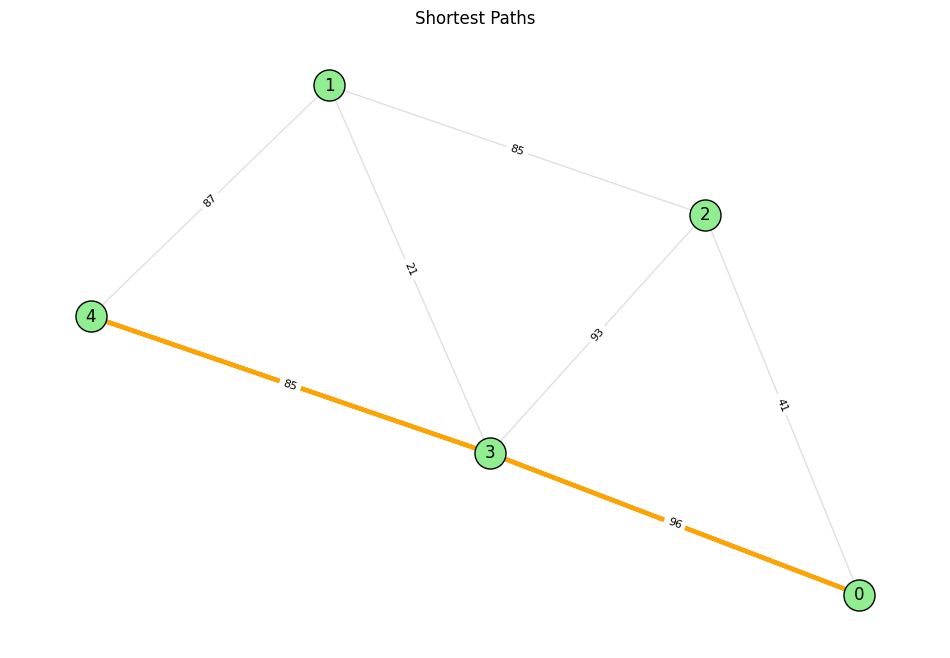


Iteration 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.6.0 24G325)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 2 rows, 2 columns and 2 nonzeros
Model fingerprint: 0xf644dc47
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  8.000000000e+01
Objective: 80.0

Iteration 2
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.6.0 24G325)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with

In [19]:
import heapq
import time
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import gurobipy as gp
from gurobipy import GRB

# ===== SECTION 1: GRAPH & SHORTEST PATH =====

def build_expanded_graph(n_physical, edges):
    G_exp = defaultdict(list)
    for u, v, mode, length in edges:
        if mode == 1:
            G_exp[(u, 1)].append(((v, 1), length))
            G_exp[(u, 1)].append(((v, 2), length))
        elif mode == 2:
            G_exp[(u, 2)].append(((v, 2), length))
            G_exp[(u, 2)].append(((v, 1), length))
    return G_exp

def dijkstra_multi_target(G_exp, targets):
    dist = defaultdict(lambda: float('inf'))
    heap = []
    for target in targets:
        dist[target] = 0
        heapq.heappush(heap, (0, target))
    while heap:
        d, node = heapq.heappop(heap)
        if d != dist[node]:
            continue
        for neighbor, length in G_exp.get(node, []):
            new_dist = d + length
            if new_dist < dist[neighbor]:
                dist[neighbor] = new_dist
                heapq.heappush(heap, (new_dist, neighbor))
    return dist

def reconstruct_path(prev, node):
    path = []
    while node is not None:
        path.append(node)
        node = prev.get(node)
    return list(reversed(path))

def find_shortest_paths(G_exp, s, t):
    best_paths = []
    best_length = float('inf')
    for start_mode in [1, 2]:
        dist = defaultdict(lambda: float('inf'))
        prev = {}
        start_node = (s, start_mode)
        dist[start_node] = 0
        heap = [(0, start_node)]
        while heap:
            current_dist, node = heapq.heappop(heap)
            if current_dist > dist[node]:
                continue
            if node[0] == t:
                if current_dist < best_length:
                    best_length = current_dist
                    best_paths = [reconstruct_path(prev, node)]
                elif current_dist == best_length:
                    best_paths.append(reconstruct_path(prev, node))
                continue
            for neighbor, length in G_exp.get(node, []):
                new_dist = current_dist + length
                if new_dist < dist[neighbor]:
                    dist[neighbor] = new_dist
                    prev[neighbor] = node
                    heapq.heappush(heap, (new_dist, neighbor))
    return best_paths, best_length

def find_near_optimal_paths(G_exp, n_physical, s, t, epsilon, d_prime, Lmin, max_paths=100):
    results = []
    for start_type in [1, 2]:
        visited_physical = [False] * n_physical
        visited_physical[s] = True
        stack = [((s, start_type), 0, [], visited_physical)]
        while stack and len(results) < max_paths:
            node, total_length, path, visited = stack.pop()
            u, _ = node
            if u == t:
                results.append((path + [node], total_length))
                continue
            for next_node, length in G_exp.get(node, []):
                v, _ = next_node
                if not visited[v]:
                    new_length = total_length + length
                    if new_length + d_prime.get(next_node, float('inf')) <= (1 + epsilon) * Lmin:
                        new_visited = visited.copy()
                        new_visited[v] = True
                        new_path = path + [node]
                        stack.append((next_node, new_length, new_path, new_visited))
    return results

def convert_path_to_model_format(path, length):
    arcs = []
    for i in range(len(path) - 1):
        u, u_mode = path[i]
        v, v_mode = path[i + 1]
        real_arc = (u, f"{v}^{v_mode}")
        arcs.append(real_arc)
        if i < len(path) - 2:
            virtual_arc = (f"{v}^{v_mode}", v)
            arcs.append(virtual_arc)
    last_node, last_mode = path[-1]
    arcs.append((f"{last_node}^{last_mode}", last_node))
    return arcs, length

# ===== VISUALIZATION =====

def draw_shortest_paths(physical_edges, shortest_paths, title="Shortest Paths"):
    G = nx.Graph()
    for u, v, mode, length in physical_edges:
        G.add_edge(u, v, weight=length, mode=mode)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12,8))
    nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=1, alpha=0.7)
    for i, path in enumerate(shortest_paths):
        color = 'red' if i==0 else 'orange'
        for j in range(len(path)-1):
            u, u_mode = path[j]
            v, v_mode = path[j+1]
            if G.has_edge(u,v):
                nx.draw_networkx_edges(G, pos, edgelist=[(u,v)], width=3, edge_color=color, alpha=0.8)
    nx.draw_networkx_nodes(G,pos,node_color='lightgreen',node_size=500, edgecolors='black')
    nx.draw_networkx_labels(G,pos)
    edge_labels={(u,v):f"{G[u][v]['weight']}" for u,v in G.edges()}
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,font_size=8)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ===== SECTION 2: SAMPLE COLUMN GENERATION =====

class ColumnGenerationModel:
    def __init__(self, data):
        self.data = data
        self.model = None

    def solve_master_problem(self, current_paths):
        model = gp.Model("MasterProblem")
        v_path={}
        for (commodity, od), paths in current_paths.items():
            for idx, path_info in enumerate(paths):
                path, length = path_info
                for t in self.data['T']:
                    v_path[(commodity, od, idx, t)] = model.addVar(lb=0, ub=1, name=f"v_{commodity}_{od}_{idx}_{t}")
        model.update()
        transport_cost = gp.quicksum(
            self.data['demands'][(commodity, od)] * sum(1 for _ in path) * v_path[(commodity, od, idx, t)]
            for (commodity, od), paths in current_paths.items() 
            for idx, (path,length) in enumerate(paths) 
            for t in self.data['T']
        )
        model.setObjective(transport_cost, GRB.MINIMIZE)
        for (commodity, od), paths in current_paths.items():
            for t in self.data['T']:
                model.addConstr(gp.quicksum(v_path[(commodity, od, idx, t)] for idx in range(len(paths))) == 1,
                               name=f"flow_{commodity}_{od}_{t}")
        model.optimize()
        duals={}
        if model.status==GRB.OPTIMAL:
            for constr in model.getConstrs():
                duals[constr.ConstrName]=constr.RHS  # temporarily use RHS to avoid .Pi
        return model.objVal, duals, model

    def pricing_subproblem(self, duals, commodity, od):
        return None  # placeholder

    def solve_with_column_generation(self, max_iterations=5):
        current_paths=self.data['paths']
        best_obj=float('inf')
        for iteration in range(max_iterations):
            print(f"\nIteration {iteration+1}")
            obj_val, duals, model=self.solve_master_problem(current_paths)
            if obj_val is None: break
            print(f"Objective: {obj_val}")
            if abs(obj_val-best_obj)<1e-6: break
            best_obj=obj_val
        return best_obj, current_paths, model

# ===== SECTION 3: RUN FULL PIPELINE =====

def main():
    n_physical=5
    edges=[
        (0,2,1,45),(0,2,2,41),(0,3,1,23),(0,3,2,96),
        (1,2,1,85),(1,3,1,13),(1,3,2,21),(1,4,1,74),(1,4,2,87),
        (2,3,1,35),(2,3,2,93),(3,4,1,67),(3,4,2,85)
    ]
    G_exp=build_expanded_graph(n_physical,edges)
    s,t=0,4
    shortest_paths, shortest_length = find_shortest_paths(G_exp,s,t)
    print(f"Shortest paths {s}->{t}: length={shortest_length}")
    for path in shortest_paths:
        print(path)

    rev_G_exp=defaultdict(list)
    for node, neighbors in G_exp.items():
        for neighbor, length in neighbors:
            rev_G_exp[neighbor].append((node,length))
    targets=[(t,1),(t,2)]
    d_prime=dijkstra_multi_target(rev_G_exp,targets)
    Lmin=min(d_prime.get((s,1),float('inf')), d_prime.get((s,2),float('inf')))
    near_paths=find_near_optimal_paths(G_exp,n_physical,s,t,0.5,d_prime,Lmin)
    print("Near-optimal paths:")
    for path,length in near_paths:
        print(path,length)
    
    all_paths_to_show = shortest_paths + [p for p,_ in near_paths[:3]]
    draw_shortest_paths(edges, all_paths_to_show)

    # Prepare sample data for Gurobi
    paths_for_model={}
    for idx,path in enumerate(shortest_paths):
        conv_path, length = convert_path_to_model_format(path,0)
        paths_for_model[('g1',(1,4))] = [(conv_path,length)]
    model_data={'T':[1,2],'paths':paths_for_model,'demands':{('g1',(1,4)):10}}
    cg_model=ColumnGenerationModel(model_data)
    obj_val, final_paths, model=cg_model.solve_with_column_generation()
    print(f"Final objective: {obj_val}")

if __name__=="__main__":
    main()


OPTIMIZED MULTIMODAL TRANSPORT NETWORK MODEL

1. FIND SHORTEST AND NEAR-OPTIMAL ROUTES
Nodes in the expanded graph:
  (0, 1): 4 edges
  (0, 2): 4 edges
  (1, 1): 6 edges
  (1, 2): 4 edges
  (2, 1): 2 edges
  (2, 2): 2 edges
  (3, 1): 2 edges
  (3, 2): 2 edges
  (4, 1): 0 edges
  (4, 2): 0 edges

Finding paths from node 0 to node 4
SHORTEST ROUTE from node 0 to node 4:
Shortest length: 90
  Path 1: [(0, 1), (3, 1), (4, 1)]
  Path 2: [(0, 1), (3, 1), (4, 2)]

NEAR-OPTIMAL PATHS (ε=0.3):
Found 4 paths
  Path 1: [(0, 1), (3, 2), (4, 1)], Length: 108
  Path 2: [(0, 1), (3, 2), (4, 2)], Length: 108
  Path 3: [(0, 1), (3, 1), (4, 2)], Length: 90

2. VISUALIZE ROUTES


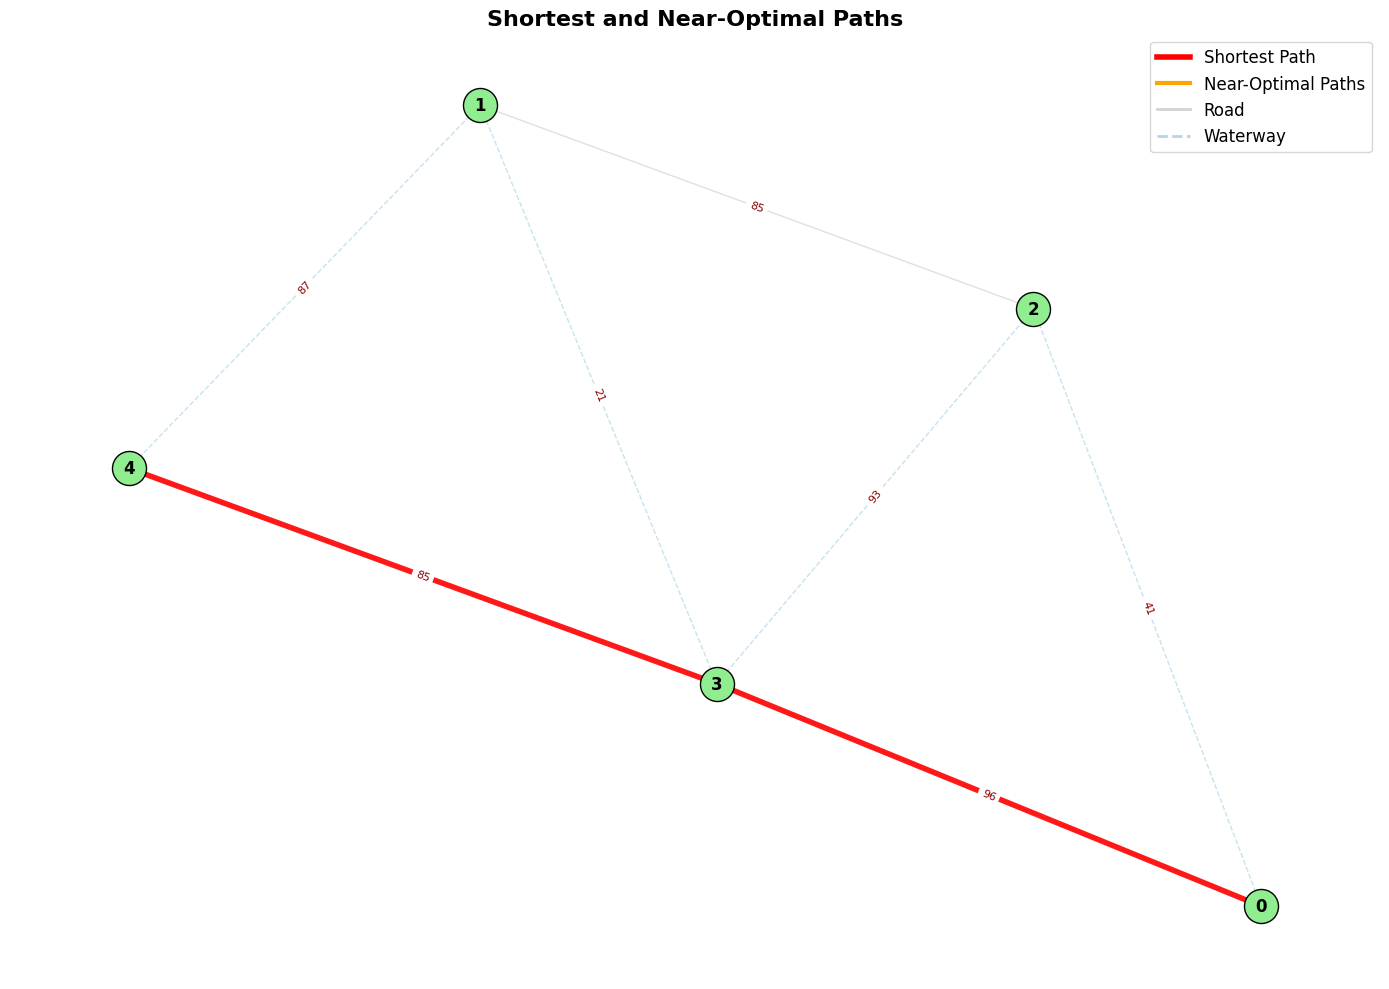


3. PREPARE DATA FOR THE OPTIMIZED MODEL
Finding path for g1: 0 -> 3
  - Found 12 paths
Finding path for g1: 1 -> 4
  - Found 20 paths
Finding path for g2: 1 -> 3
  - Found 8 paths

Total paths found: 40

MODEL DATA:
- Number of real arcs: 14
- Number of virtual arcs: 6
- Total arcs: 20

4. SOLVE THE OPTIMIZED MODEL
BUILDING THE OPTIMIZED MODEL...
SOLVING THE MODEL...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/dinhxuantruong/2022/Jupyter/test_env/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/h4/zst5rtt5313_x9ycg4yt3ymr0000gn/T/920ea793ae1c4af097ac770de286b344-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/h4/zst5rtt5313_x9ycg4yt3ymr0000gn/T/920ea793ae1c4af097ac770de286b344-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 68 COLUMNS
At line 715 RHS
At line 779 BOUNDS
At line 872 ENDATA
Problem MODEL has 63 rows, 134 columns and 532 ele

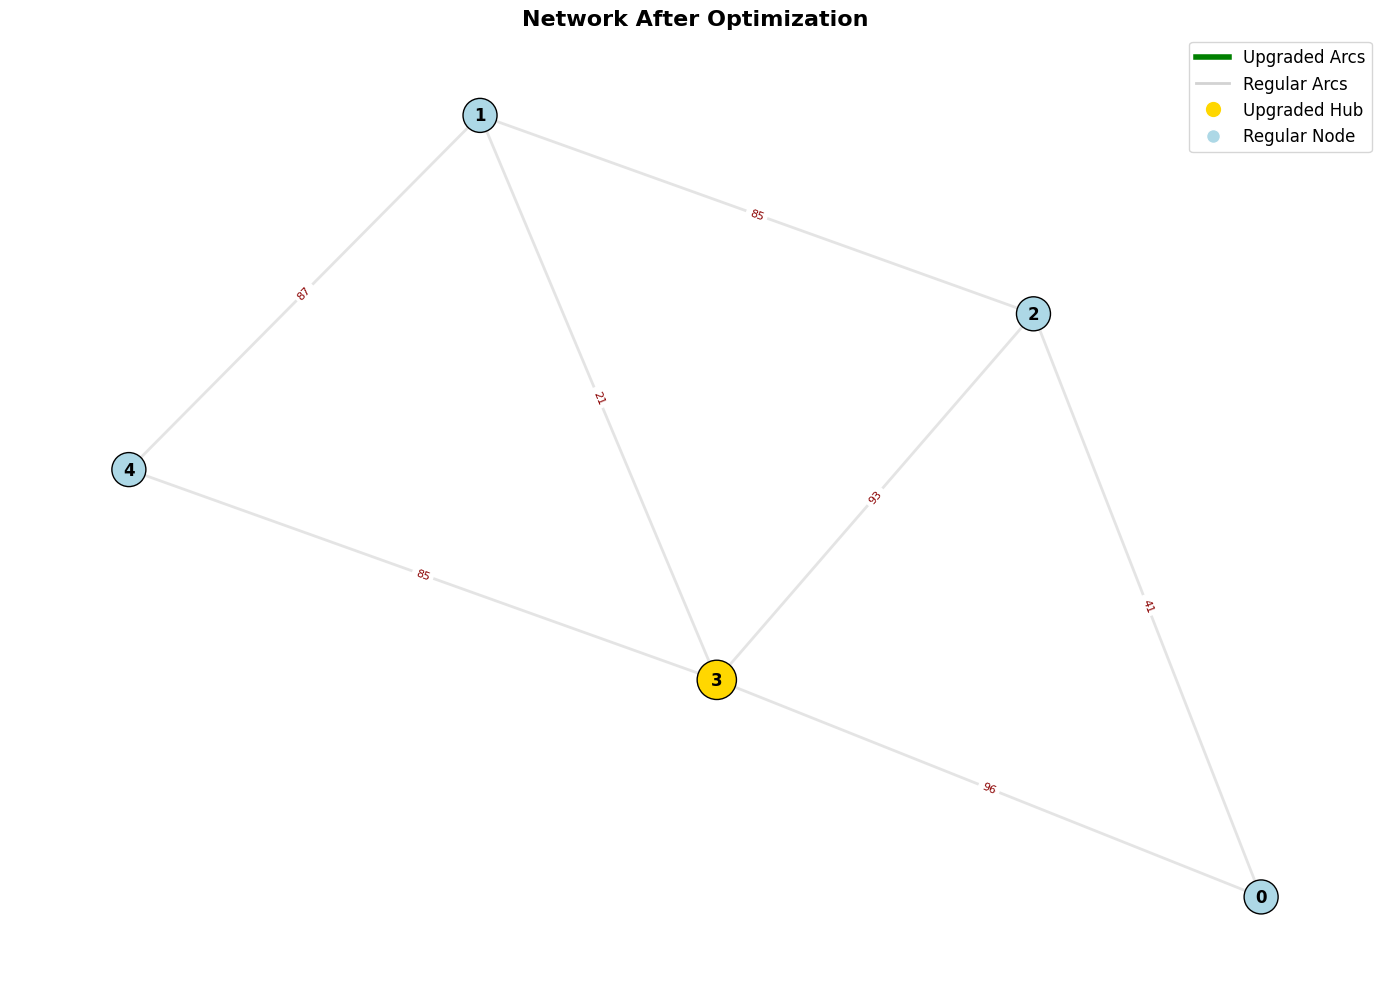

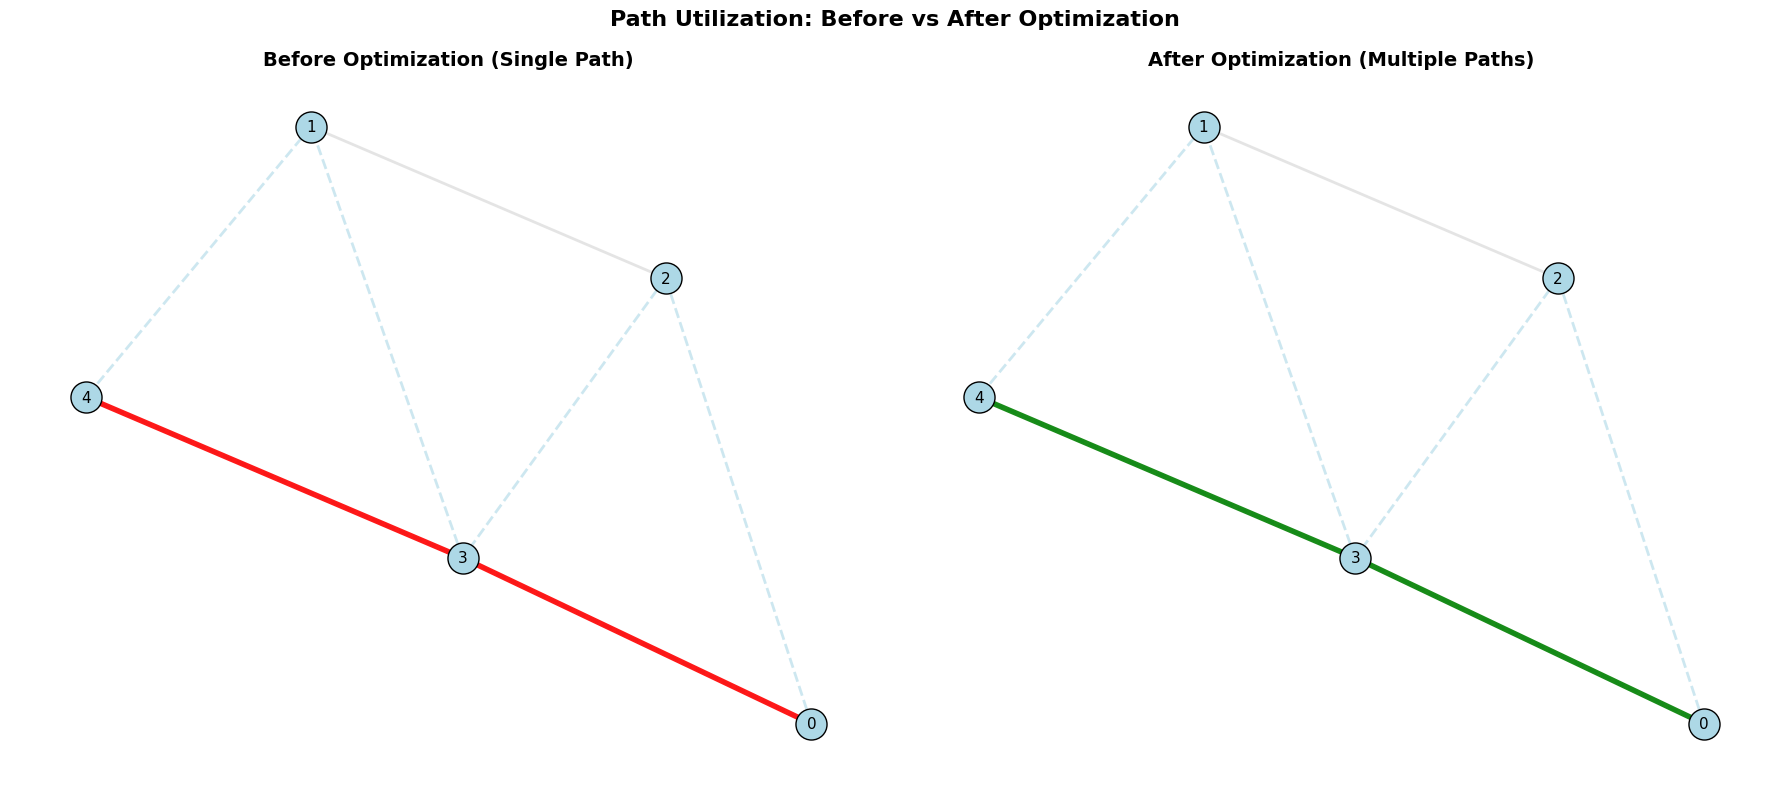

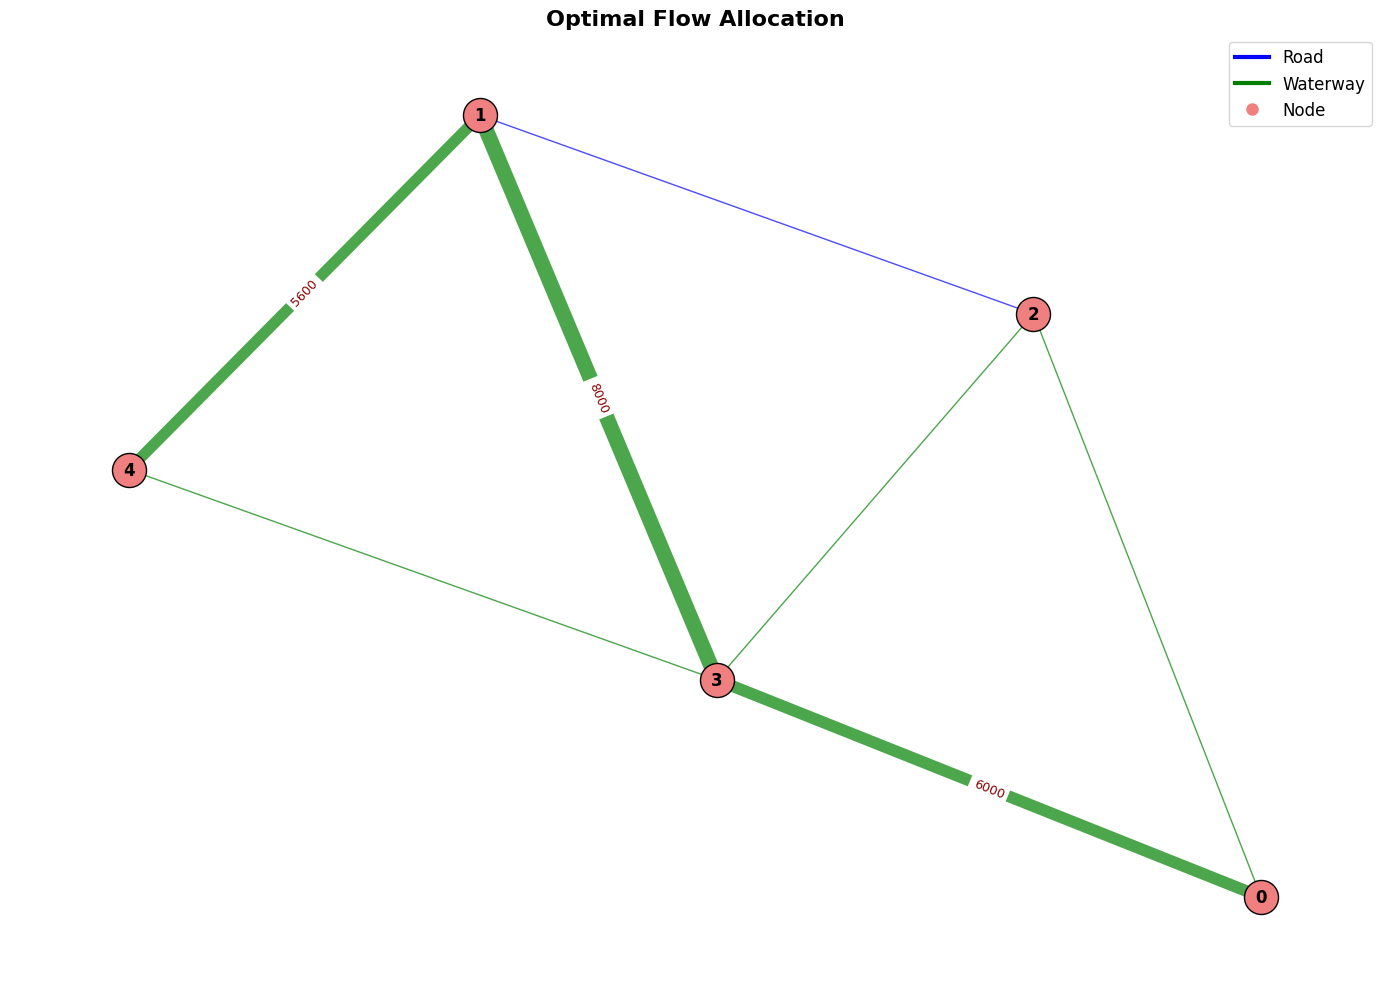


SUMMARY OF RESULTS
📈 OPTIMIZATION EFFECTIVENESS:
  - Total cost: 14053200.0
  - Number of paths used: 2
  - Optimal flow allocation across 3 paths

🔧 INFRASTRUCTURE IMPROVEMENTS:
  - Upgraded hubs: ['Node 3']
  - Upgraded routes: 0

🚀 BENEFITS:
  - Increase transport capacity
  - Reduce congestion on main paths
  - Distribute load more effectively
  - Optimize operating costs


In [18]:
import heapq
import time
import copy
from collections import defaultdict
import pulp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# ======== SECTION 1: FIND SHORTEST ROUTE & VISUALIZATION ========

def build_expanded_graph(n_physical, edges):
    """Build expanded graph from physical network - UPDATED VERSION"""
    G_exp = defaultdict(list)
    
    # Ensure every node is in the graph
    for i in range(n_physical):
        for mode in [1, 2]:
            G_exp[(i, mode)] = []  # Initialize nodes even when they have no edges
    
    for u, v, mode, length in edges:
        if mode == 1:  # Road
            G_exp[(u, 1)].append(((v, 1), length))  # Road -> Road
            G_exp[(u, 1)].append(((v, 2), length))  # Road -> Water
        elif mode == 2:  # Water
            G_exp[(u, 2)].append(((v, 2), length))  # Water -> Water
            G_exp[(u, 2)].append(((v, 1), length))  # Water -> Road
    
    return G_exp, n_physical

def dijkstra_multi_target(G_exp, targets):
    """Dijkstra with multiple targets - UPDATED VERSION"""
    dist = defaultdict(lambda: float('inf'))
    heap = []
    
    for target in targets:
        if target in G_exp:  # Check if the target exists
            dist[target] = 0
            heapq.heappush(heap, (0, target))
    
    while heap:
        d, node = heapq.heappop(heap)
        if d != dist[node]:
            continue
        
        # Verify the node exists in G_exp
        if node not in G_exp:
            continue
            
        for neighbor, length in G_exp[node]:
            new_dist = d + length
            if new_dist < dist[neighbor]:
                dist[neighbor] = new_dist
                heapq.heappush(heap, (new_dist, neighbor))
    
    return dist

def find_shortest_paths(G_exp, s, t):
    """Find all shortest paths from s to t - UPDATED VERSION"""
    best_paths = []
    best_length = float('inf')
    
    for start_mode in [1, 2]:
        start_node = (s, start_mode)
        
        # Ensure the start node exists
        if start_node not in G_exp:
            continue
            
        # Use defaultdict to avoid KeyError
        dist = defaultdict(lambda: float('inf'))
        prev = defaultdict(lambda: None)
        
        dist[start_node] = 0
        heap = [(0, start_node)]
        
        while heap:
            current_dist, node = heapq.heappop(heap)
            
            if current_dist > dist[node]:
                continue
                
            # Check if the destination has been reached
            if node[0] == t:
                if current_dist < best_length:
                    best_length = current_dist
                    best_paths = [reconstruct_path(prev, node)]
                elif current_dist == best_length:
                    path = reconstruct_path(prev, node)
                    if path not in best_paths:
                        best_paths.append(path)
                continue
                
            # Verify the node exists in G_exp
            if node not in G_exp:
                continue
                
            for neighbor, length in G_exp[node]:
                new_dist = current_dist + length
                if new_dist < dist[neighbor]:
                    dist[neighbor] = new_dist
                    prev[neighbor] = node
                    heapq.heappush(heap, (new_dist, neighbor))
    
    return best_paths, best_length

def reconstruct_path(prev, node):
    """Reconstruct paths from the predecessor dictionary"""
    path = []
    while node is not None:
        path.append(node)
        node = prev[node]
    return list(reversed(path))

def find_near_optimal_paths(G_exp, n_physical, s, t, epsilon, d_prime, Lmin, max_paths=50):
    """Find near-optimal paths - UPDATED VERSION"""
    results = []
    
    for start_type in [1, 2]:
        start_node = (s, start_type)
        
        # Ensure the start node exists
        if start_node not in G_exp:
            continue
            
        visited_physical = [False] * n_physical
        visited_physical[s] = True
        stack = [(start_node, 0, [], visited_physical)]
        
        while stack and len(results) < max_paths:
            node, total_length, path, visited = stack.pop()
            u, _ = node
            
            if u == t:
                full_path = path + [node]
                results.append((full_path, total_length))
                continue
                
            # Verify the node exists in G_exp
            if node not in G_exp:
                continue
                
            for next_node, length in G_exp[node]:
                v, _ = next_node
                if not visited[v]:
                    new_length = total_length + length
                    # Check the near-optimal condition
                    bound_check = new_length + d_prime.get(next_node, float('inf'))
                    if bound_check <= (1 + epsilon) * Lmin:
                        new_visited = visited.copy()
                        new_visited[v] = True
                        new_path = path + [node]
                        stack.append((next_node, new_length, new_path, new_visited))
    
    return results

def find_all_paths_dfs(G_exp, n_physical, s, t, max_paths=100, max_time=30):
    """Find all paths using DFS - UPDATED VERSION"""
    start_time = time.time()
    results = []
    
    for start_type in [1, 2]:
        start_node = (s, start_type)
        
        # Ensure the start node exists
        if start_node not in G_exp:
            continue
            
        visited_physical = [False] * n_physical
        visited_physical[s] = True
        stack = [(start_node, 0, [], visited_physical)]
        
        while stack:
            if time.time() - start_time > max_time or len(results) >= max_paths:
                return results
                
            node, total_length, path, visited = stack.pop()
            u, _ = node
            
            if u == t:
                full_path = path + [node]
                results.append((full_path, total_length))
                continue
                
            # Verify the node exists in G_exp
            if node not in G_exp:
                continue
                
            for next_node, length in G_exp[node]:
                v, _ = next_node
                if not visited[v]:
                    new_path = path + [node]
                    new_length = total_length + length
                    new_visited = visited.copy()
                    new_visited[v] = True
                    stack.append((next_node, new_length, new_path, new_visited))
    
    return results

def convert_path_to_model_format(path, length):
    """Convert paths from expanded format to model format"""
    arcs = []
    for i in range(len(path) - 1):
        u, u_mode = path[i]
        v, v_mode = path[i + 1]
        
        # Create real arc from u to virtual node of v
        real_arc = (u, f"{v}^{v_mode}")
        arcs.append(real_arc)
        
        # If not the last step, add virtual arc
        if i < len(path) - 2:
            virtual_arc = (f"{v}^{v_mode}", v)
            arcs.append(virtual_arc)
    
    # Add virtual arc for the destination
    last_node, last_mode = path[-1]
    virtual_arc_dest = (f"{last_node}^{last_mode}", last_node)
    arcs.append(virtual_arc_dest)
    
    return arcs, length

# ======== VISUALIZATION FUNCTIONS ========

def draw_shortest_paths(physical_edges, shortest_paths, near_optimal_paths=None, title="Shortest Paths"):
    """Plot the physical network with the shortest and near-optimal paths"""
    G = nx.Graph()
    
    # Add nodes and edges
    for u, v, mode, length in physical_edges:
        G.add_edge(u, v, weight=length, mode=mode)
    
    pos = nx.spring_layout(G, seed=42)
    
    plt.figure(figsize=(14, 10))
    
    # Draw all edges
    all_edges = list(G.edges())
    edge_colors = []
    edge_styles = []
    edge_widths = []
    
    for u, v in all_edges:
        mode = G[u][v]['mode']
        edge_colors.append("lightgray" if mode == 1 else "lightblue")
        edge_styles.append('-' if mode == 1 else '--')
        edge_widths.append(1)
    
    # Draw regular edges
    for i, (u, v) in enumerate(all_edges):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], 
                              width=edge_widths[i], 
                              edge_color=edge_colors[i],
                              style=edge_styles[i],
                              alpha=0.7)
    
    # Draw shortest paths
    shortest_edges = set()
    for path in shortest_paths:
        for j in range(len(path) - 1):
            u, u_mode = path[j]
            v, v_mode = path[j + 1]
            if G.has_edge(u, v):
                shortest_edges.add((u, v))
    
    if shortest_edges:
        nx.draw_networkx_edges(G, pos, edgelist=list(shortest_edges),
                              width=4, edge_color='red', alpha=0.9,
                              label='Shortest Path')
    
    # Draw near-optimal paths
    if near_optimal_paths:
        near_optimal_edges = set()
        for path, length in near_optimal_paths:
            for j in range(len(path) - 1):
                u, u_mode = path[j]
                v, v_mode = path[j + 1]
                if G.has_edge(u, v):
                    near_optimal_edges.add((u, v))
        
        # Remove edges already in the shortest path
        near_optimal_edges = near_optimal_edges - shortest_edges
        
        if near_optimal_edges:
            nx.draw_networkx_edges(G, pos, edgelist=list(near_optimal_edges),
                                  width=3, edge_color='orange', alpha=0.7,
                                  label='Near-Optimal Paths')
    
    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color='lightgreen', 
                          node_size=600, edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    
    # Edge labels
    edge_labels = {(u, v): f"{G[u][v]['weight']}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                               font_size=8, font_color='darkred')
    
    # Legend
    legend_elements = [
        plt.Line2D([0], [0], color='red', lw=4, label='Shortest Path'),
        plt.Line2D([0], [0], color='orange', lw=3, label='Near-Optimal Paths'),
        plt.Line2D([0], [0], color='lightgray', lw=2, label='Road'),
        plt.Line2D([0], [0], color='lightblue', lw=2, linestyle='--', label='Waterway'),
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def draw_network_upgrades(physical_edges, upgraded_arcs, upgraded_hubs, title="Network After Upgrades"):
    """Draw the network after upgrades"""
    G = nx.Graph()
    
    for u, v, mode, length in physical_edges:
        G.add_edge(u, v, weight=length, mode=mode)
    
    pos = nx.spring_layout(G, seed=42)
    
    plt.figure(figsize=(14, 10))
    
    # Categorize edges
    regular_edges = []
    upgraded_edges = []
    
    for u, v in G.edges():
        edge_data = G[u][v]
        is_upgraded = False
        
        # Check whether this edge was upgraded
        for arc in upgraded_arcs:
            start_node, end_virtual = arc
            end_node = int(end_virtual.split('^')[0])
            if (start_node == u and end_node == v) or (start_node == v and end_node == u):
                is_upgraded = True
                break
        
        if is_upgraded:
            upgraded_edges.append((u, v))
        else:
            regular_edges.append((u, v))
    
    # Draw regular edges
    nx.draw_networkx_edges(G, pos, edgelist=regular_edges, 
                          edge_color='lightgray', width=2, alpha=0.6)
    
    # Draw upgraded edges
    nx.draw_networkx_edges(G, pos, edgelist=upgraded_edges,
                          edge_color='green', width=4, alpha=0.8, 
                          style='-', label='Upgraded Arcs')
    
    # Draw nodes
    node_colors = []
    node_sizes = []
    for node in G.nodes():
        if node in upgraded_hubs:
            node_colors.append('gold')
            node_sizes.append(800)
        else:
            node_colors.append('lightblue')
            node_sizes.append(600)
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=node_sizes, edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    
    # Edge labels
    edge_labels = {(u, v): f"{G[u][v]['weight']}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                               font_size=8, font_color='darkred')
    
    # Legend
    legend_elements = [
        plt.Line2D([0], [0], color='green', lw=4, label='Upgraded Arcs'),
        plt.Line2D([0], [0], color='lightgray', lw=2, label='Regular Arcs'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', 
                  markersize=12, label='Upgraded Hub'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
                  markersize=10, label='Regular Node'),
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def draw_path_comparison(physical_edges, before_paths, after_paths, 
                        before_title="Before Upgrades", after_title="After Upgrades",
                        main_title="Path Comparison: Before vs After Upgrades"):
    """Compare paths before and after upgrades"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    G = nx.Graph()
    for u, v, mode, length in physical_edges:
        G.add_edge(u, v, weight=length, mode=mode)
    
    pos = nx.spring_layout(G, seed=42)
    
    # Before upgrades - LEFT PLOT
    # Draw all edges
    all_edges = list(G.edges())
    for u, v in all_edges:
        mode = G[u][v]['mode']
        color = "lightgray" if mode == 1 else "lightblue"
        style = '-' if mode == 1 else '--'
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], ax=ax1,
                              width=2, edge_color=color, style=style, alpha=0.6)
    
    # Draw paths before upgrades
    before_edges = set()
    for path in before_paths:
        for j in range(len(path) - 1):
            u, u_mode = path[j]
            v, v_mode = path[j + 1]
            if G.has_edge(u, v):
                before_edges.add((u, v))
    
    if before_edges:
        nx.draw_networkx_edges(G, pos, edgelist=list(before_edges), ax=ax1,
                              width=4, edge_color='red', alpha=0.9)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_color='lightblue', 
                          node_size=500, edgecolors='black')
    nx.draw_networkx_labels(G, pos, ax=ax1, font_size=11)
    
    ax1.set_title(before_title, fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # After upgrades - RIGHT PLOT  
    # Draw all edges
    for u, v in all_edges:
        mode = G[u][v]['mode']
        color = "lightgray" if mode == 1 else "lightblue"
        style = '-' if mode == 1 else '--'
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], ax=ax2,
                              width=2, edge_color=color, style=style, alpha=0.6)
    
    # Draw paths after upgrades
    after_edges = set()
    for path in after_paths:
        for j in range(len(path) - 1):
            u, u_mode = path[j]
            v, v_mode = path[j + 1]
            if G.has_edge(u, v):
                after_edges.add((u, v))
    
    if after_edges:
        nx.draw_networkx_edges(G, pos, edgelist=list(after_edges), ax=ax2,
                              width=4, edge_color='green', alpha=0.9)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, ax=ax2, node_color='lightblue', 
                          node_size=500, edgecolors='black')
    nx.draw_networkx_labels(G, pos, ax=ax2, font_size=11)
    
    ax2.set_title(after_title, fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    # Main title
    plt.suptitle(main_title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

def draw_flow_allocation(physical_edges, flow_results, title="Flow Allocation Results"):
    """Visualize flow allocation results"""
    G = nx.Graph()
    
    for u, v, mode, length in physical_edges:
        G.add_edge(u, v, weight=length, mode=mode)
    
    pos = nx.spring_layout(G, seed=42)
    
    plt.figure(figsize=(14, 10))
    
    # Draw edges with thickness proportional to flow
    edge_widths = []
    edge_colors = []
    
    max_flow = max(flow_results.values()) if flow_results else 1
    
    for u, v in G.edges():
        flow_key = (min(u, v), max(u, v))
        flow = flow_results.get(flow_key, 0)
        
        # Edge thickness proportional to flow
        width = 1 + (flow / max_flow) * 10
        edge_widths.append(width)
        
        # Color by mode
        mode = G[u][v]['mode']
        edge_colors.append("blue" if mode == 1 else "green")
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=edge_widths, 
                          edge_color=edge_colors, alpha=0.7)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightcoral', 
                          node_size=600, edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    
    # Add flow labels
    flow_labels = {}
    for (u, v), flow in flow_results.items():
        if G.has_edge(u, v):
            flow_labels[(u, v)] = f"{flow:.0f}"
    
    nx.draw_networkx_edge_labels(G, pos, edge_labels=flow_labels,
                               font_size=9, font_color='darkred')
    
    # Legend
    legend_elements = [
        plt.Line2D([0], [0], color='blue', lw=3, label='Road'),
        plt.Line2D([0], [0], color='green', lw=3, label='Waterway'),
        plt.Line2D([0], [0], color='lightcoral', marker='o', markersize=8, 
                  label='Node', linestyle='None'),
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# ======== SECTION 2: OPTIMIZED MODEL WITH PULP ========

def create_optimization_model(data):
    """Build and solve the optimal model with PuLP"""
    print("BUILDING THE OPTIMIZED MODEL...")
    
    # Initialize model
    model = pulp.LpProblem("Multimodal_Transport_Optimization", pulp.LpMinimize)
    
    # Decision variables
    v_path = {}
    y_hub = {}
    y_arc = {}
    u_hub = {}
    x_arc = {}
    
    # Initialize flow variables for paths
    for (commodity, od), paths in data['paths'].items():
        for idx, (path, length) in enumerate(paths):
            for t in data['T']:
                var_name = f"v_{commodity}_{od[0]}_{od[1]}_p{idx}_t{t}"
                v_path[(commodity, od, idx, t)] = pulp.LpVariable(var_name, lowBound=0, upBound=1)
    
    # Hub upgrade variables
    for h in data['potential_hubs']:
        for l in [0, 1]:
            for t in data['T']:
                y_hub[(h, l, t)] = pulp.LpVariable(f"y_hub_{h}_{l}_{t}", cat='Binary')
    
    # Arc upgrade variables
    for arc in data['potential_arcs']:
        for l in [0, 1]:
            for t in data['T']:
                y_arc[(arc[0], arc[1], l, t)] = pulp.LpVariable(f"y_arc_{arc[0]}_{arc[1]}_{l}_{t}", cat='Binary')
    
    # Flow variables through hubs and arcs
    for h in data['H']:
        for t in data['T']:
            u_hub[(h, t)] = pulp.LpVariable(f"u_hub_{h}_{t}", lowBound=0)
    
    for arc in data['A']:
        for t in data['T']:
            x_arc[(arc[0], arc[1], t)] = pulp.LpVariable(f"x_arc_{arc[0]}_{arc[1]}_{t}", lowBound=0)
    
    # OBJECTIVE FUNCTION
    investment_cost = pulp.lpSum(
        data['hub_upgrade_cost'] * data['hub_capacity'][l] * y_hub[(h, l, t)]
        for h in data['potential_hubs'] for l in [0, 1] for t in data['T']
    ) + pulp.lpSum(
        data['arc_upgrade_costs'][a] * data['arc_capacities'][a][l] * y_arc[(a[0], a[1], l, t)]
        for a in data['potential_arcs'] for l in [0, 1] for t in data['T']
    )
    
    service_cost = pulp.lpSum(
        data['hub_service_cost'][h] * u_hub[(h, t)]
        for h in data['H'] for t in data['T']
    )
    
    transport_cost = pulp.lpSum(0)
    for commodity, od_pairs in data['OD_pairs'].items():
        for od in od_pairs:
            demand = data['demands'][(commodity, od)]
            if (commodity, od) in data['paths']:
                for idx, (path, length) in enumerate(data['paths'][(commodity, od)]):
                    # Calculate transport cost for the path
                    path_cost = 0
                    mode_switches = 0
                    prev_mode = None
                    
                    for arc in path:
                        path_cost += data['arc_costs'].get(arc, 1)  # Default cost = 1
                        
                        # Identify the current mode
                        current_mode = 'road' if str(arc[1]).endswith('^1') else 'water'
                        if prev_mode and prev_mode != current_mode:
                            mode_switches += 1
                        prev_mode = current_mode
                    
                    path_cost += mode_switches * data['switch_cost']
                    
                    for t in data['T']:
                        transport_cost += path_cost * demand * v_path[(commodity, od, idx, t)]
    
    model += investment_cost + service_cost + transport_cost
    
    # CONSTRAINTS
    # 1. Flow allocation constraints
    for commodity, od_pairs in data['OD_pairs'].items():
        for od in od_pairs:
            for t in data['T']:
                if (commodity, od) in data['paths']:
                    model += pulp.lpSum(
                        v_path[(commodity, od, idx, t)] 
                        for idx in range(len(data['paths'][(commodity, od)]))
                    ) == 1, f"flow_alloc_{commodity}_{od}_{t}"
    
    # 2. Hub flow calculation
    for h in data['H']:
        for t in data['T']:
            total_flow = pulp.lpSum(0)
            for commodity, od_pairs in data['OD_pairs'].items():
                for od in od_pairs:
                    demand = data['demands'][(commodity, od)]
                    if (commodity, od) in data['paths']:
                        for idx, (path, length) in enumerate(data['paths'][(commodity, od)]):
                            # Check if the path passes through the hub
                            if any(arc[1] == str(h) or arc[1] == h for arc in path):
                                total_flow += demand * v_path[(commodity, od, idx, t)]
            
            model += u_hub[(h, t)] == total_flow, f"hub_flow_{h}_{t}"
    
    # 3. Arc flow calculation
    for arc in data['A']:
        for t in data['T']:
            total_flow = pulp.lpSum(0)
            for commodity, od_pairs in data['OD_pairs'].items():
                for od in od_pairs:
                    demand = data['demands'][(commodity, od)]
                    if (commodity, od) in data['paths']:
                        for idx, (path, length) in enumerate(data['paths'][(commodity, od)]):
                            if arc in path:
                                total_flow += demand * v_path[(commodity, od, idx, t)]
            
            model += x_arc[(arc[0], arc[1], t)] == total_flow, f"arc_flow_{arc[0]}_{arc[1]}_{t}"
    
    # 4. Capacity constraints
    for h in data['potential_hubs']:
        for t in data['T']:
            model += u_hub[(h, t)] <= pulp.lpSum(
                data['hub_capacity'][l] * y_hub[(h, l, t)] for l in [0, 1]
            ), f"hub_capacity_{h}_{t}"
    
    for arc in data['potential_arcs']:
        for t in data['T']:
            model += x_arc[(arc[0], arc[1], t)] <= pulp.lpSum(
                data['arc_capacities'][arc][l] * y_arc[(arc[0], arc[1], l, t)] for l in [0, 1]
            ), f"arc_capacity_{arc[0]}_{arc[1]}_{t}"
    
    # 5. Logic constraints
    for h in data['potential_hubs']:
        for t in data['T']:
            model += pulp.lpSum(y_hub[(h, l, t)] for l in [0, 1]) == 1, f"hub_logic_{h}_{t}"
    
    for arc in data['potential_arcs']:
        for t in data['T']:
            model += pulp.lpSum(y_arc[(arc[0], arc[1], l, t)] for l in [0, 1]) == 1, f"arc_logic_{arc[0]}_{arc[1]}_{t}"
    
    # 6. Non-decreasing capacity constraints
    for h in data['potential_hubs']:
        for i in range(len(data['T']) - 1):
            t_current = data['T'][i]
            t_next = data['T'][i + 1]
            model += pulp.lpSum(
                data['hub_capacity'][l] * y_hub[(h, l, t_next)] for l in [0, 1]
            ) >= pulp.lpSum(
                data['hub_capacity'][l] * y_hub[(h, l, t_current)] for l in [0, 1]
            ), f"hub_non_decr_{h}_{t_current}_{t_next}"
    
    for arc in data['potential_arcs']:
        for i in range(len(data['T']) - 1):
            t_current = data['T'][i]
            t_next = data['T'][i + 1]
            model += pulp.lpSum(
                data['arc_capacities'][arc][l] * y_arc[(arc[0], arc[1], l, t_next)] for l in [0, 1]
            ) >= pulp.lpSum(
                data['arc_capacities'][arc][l] * y_arc[(arc[0], arc[1], l, t_current)] for l in [0, 1]
            ), f"arc_non_decr_{arc[0]}_{arc[1]}_{t_current}_{t_next}"
    
    print("SOLVING THE MODEL...")
    model.solve(pulp.PULP_CBC_CMD(msg=1))
    
    print(f"Status: {pulp.LpStatus[model.status]}")
    print(f"Total cost optimal: {pulp.value(model.objective):.2f}")
    
    # Gather results
    results = {
        'status': pulp.LpStatus[model.status],
        'objective': pulp.value(model.objective),
        'investment_cost': pulp.value(investment_cost),
        'service_cost': pulp.value(service_cost),
        'transport_cost': pulp.value(transport_cost),
        'upgraded_hubs': [],
        'upgraded_arcs': [],
        'flow_allocation': {},
        'model': model
    }
    
    # Identify upgraded hubs
    for h in data['potential_hubs']:
        for t in data['T']:
            if pulp.value(y_hub[(h, 1, t)]) > 0.5:
                results['upgraded_hubs'].append(h)
                break
    
    # Identify upgraded arcs
    for arc in data['potential_arcs']:
        for t in data['T']:
            if pulp.value(y_arc[(arc[0], arc[1], 1, t)]) > 0.5:
                results['upgraded_arcs'].append(arc)
                break
    
    # Collect flow allocation
    for arc in data['A']:
        if arc in data['real_arcs']:  # Only consider real arcs
            total_flow = 0
            for t in data['T']:
                total_flow += pulp.value(x_arc[(arc[0], arc[1], t)])
            if total_flow > 0:
                start_node = arc[0]
                end_virtual = arc[1]
                end_node = int(end_virtual.split('^')[0])
                edge_key = (min(start_node, end_node), max(start_node, end_node))
                results['flow_allocation'][edge_key] = total_flow
    
    return results

# ======== SECTION 3: RUN FULL PIPELINE WORKFLOW ========

def main():
    print("=" * 70)
    print("OPTIMIZED MULTIMODAL TRANSPORT NETWORK MODEL")
    print("=" * 70)
    
    # ========== STEP 1: FIND ROUTES ==========
    print("\n1. FIND SHORTEST AND NEAR-OPTIMAL ROUTES")
    
    # Physical network data
    n_physical = 5
    physical_edges = [
        (0, 2, 1, 45), (0, 2, 2, 41),
        (0, 3, 1, 23), (0, 3, 2, 96),
        (1, 2, 1, 85),
        (1, 3, 1, 13), (1, 3, 2, 21),
        (1, 4, 1, 74), (1, 4, 2, 87),
        (2, 3, 1, 35), (2, 3, 2, 93),
        (3, 4, 1, 67), (3, 4, 2, 85)
    ]
    
    # Build expanded graph - USING UPDATED VERSION
    G_exp, _ = build_expanded_graph(n_physical, physical_edges)
    
    # Check nodes in the graph
    print("Nodes in the expanded graph:")
    for node in sorted(G_exp.keys()):
        print(f"  {node}: {len(G_exp[node])} edges")
    
    # Find the shortest path for the example
    s, t = 0, 4
    print(f"\nFinding paths from node {s} to node {t}")
    
    shortest_paths, shortest_length = find_shortest_paths(G_exp, s, t)
    
    if shortest_paths:
        print(f"SHORTEST ROUTE from node {s} to node {t}:")
        print(f"Shortest length: {shortest_length}")
        for i, path in enumerate(shortest_paths):
            print(f"  Path {i+1}: {path}")
    else:
        print(f"No paths found from {s} to {t}")
        # Exit or handle the situation when no paths exist
        return
    
    # Find near-optimal paths
    rev_G_exp = defaultdict(list)
    for node, neighbors in G_exp.items():
        for neighbor, length in neighbors:
            rev_G_exp[neighbor].append((node, length))
    
    targets = [(t, 1), (t, 2)]
    d_prime = dijkstra_multi_target(rev_G_exp, targets)
    Lmin = min(d_prime.get((s, 1), float('inf')), d_prime.get((s, 2), float('inf')))
    
    epsilon = 0.3
    near_optimal_paths = find_near_optimal_paths(G_exp, n_physical, s, t, epsilon, d_prime, Lmin, max_paths=10)
    
    print(f"\nNEAR-OPTIMAL PATHS (ε={epsilon}):")
    print(f"Found {len(near_optimal_paths)} paths")
    for i, (path, length) in enumerate(near_optimal_paths[:3]):  # Display the first 3 paths
        print(f"  Path {i+1}: {path}, Length: {length}")
    
    # ========== STEP 2: VISUALIZE ROUTES ==========
    print("\n2. VISUALIZE ROUTES")
    
    # Draw shortest paths and near-optimal paths
    draw_shortest_paths(physical_edges, shortest_paths, near_optimal_paths,
                       "Shortest and Near-Optimal Paths")
    
    # ========== STEP 3: PREPARE DATA FOR THE OPTIMIZED MODEL ==========
    print("\n3. PREPARE DATA FOR THE OPTIMIZED MODEL")
    
    # Define OD pairs (convert from 0-based to 1-based for the model)
    OD_pairs_physical = {
        'g1': [(0, 3), (1, 4)],  # Passenger
        'g2': [(1, 3)]            # Rice
    }
    
    # Find all paths for each OD pair
    all_paths_for_model = {}
    total_paths = 0
    
    for commodity, od_list in OD_pairs_physical.items():
        for od_pair in od_list:
            s_phys, t_phys = od_pair
            print(f"Finding path for {commodity}: {s_phys} -> {t_phys}")
            
            # Find all paths
            paths = find_all_paths_dfs(G_exp, n_physical, s_phys, t_phys, max_paths=20, max_time=10)
            converted_paths = []
            
            for path, length in paths:
                model_path, path_length = convert_path_to_model_format(path, length)
                converted_paths.append((model_path, path_length))
            
            # Convert nodes to 1-based indexing for the model
            new_od = (s_phys + 1, t_phys + 1)
            all_paths_for_model[(commodity, new_od)] = converted_paths
            total_paths += len(converted_paths)
            
            print(f"  - Found {len(converted_paths)} paths")
    
    print(f"\nTotal paths found: {total_paths}")
    
    # Check if no paths are found
    if total_paths == 0:
        print("No paths found for any OD pairs. Terminating program.")
        return
    
    # Prepare data for the model
    model_data = {
        'T': [1, 2],
        'real_nodes': [1, 2, 3, 4, 5],
        'virtual_nodes': ['3^1', '3^2', '4^1', '4^2', '5^1', '5^2'],
        'H': [3],  # Hub at Can Tho (node 3 in 1-based, corresponds to node 2 in 0-based)
        'potential_hubs': [3],
        'existing_hubs': [],
        'A': [],
        'real_arcs': [],
        'virtual_arcs': [],
        'potential_arcs': [(3, '4^1'), (3, '4^2')],  # Candidate arcs from Can Tho to Ho Chi Minh City
        'commodities': {'passenger': 'g1', 'rice': 'g2'},
        'OD_pairs': {
            'g1': [(1, 4), (2, 5)],  # 0->3 becomes 1->4, 1->4 becomes 2->5
            'g2': [(2, 4)]           # 1->3 becomes 2->4
        },
        'paths': all_paths_for_model,
        'arc_costs': {},
        'switch_cost': 2,
        'hub_service_cost': {3: 1},
        'hub_upgrade_cost': 1000,
        'hub_capacity': {0: 2000, 1: 7000},
        'arc_upgrade_costs': {(3, '4^1'): 800, (3, '4^2'): 500},
        'arc_capacities': {
            (3, '4^1'): {0: 0, 1: 3000},  # Road capacity
            (3, '4^2'): {0: 0, 1: 4000}   # Waterway capacity
        },
        'existing_hub_capacity': 2000,
        'existing_arc_capacity': 2000,
        'demands': {
            ('g1', (1, 4)): 3000,  # Passenger from An Giang -> Ho Chi Minh City
            ('g1', (2, 5)): 2800,  # Passenger from Dong Thap -> Vinh Long
            ('g2', (2, 4)): 4000   # Rice from Dong Thap -> Ho Chi Minh City
        }
    }
    
    # Collect all arcs from paths
    for paths_list in all_paths_for_model.values():
        for path, length in paths_list:
            for arc in path:
                if arc not in model_data['A']:
                    model_data['A'].append(arc)
                if '^' in str(arc[1]):  # Real arc
                    if arc not in model_data['real_arcs']:
                        model_data['real_arcs'].append(arc)
                else:  # Virtual arc
                    if arc not in model_data['virtual_arcs']:
                        model_data['virtual_arcs'].append(arc)
    
    # Initialize arc costs (simplified)
    for arc in model_data['A']:
        model_data['arc_costs'][arc] = 1  # Default cost
    
    print(f"\nMODEL DATA:")
    print(f"- Number of real arcs: {len(model_data['real_arcs'])}")
    print(f"- Number of virtual arcs: {len(model_data['virtual_arcs'])}")
    print(f"- Total arcs: {len(model_data['A'])}")
    
    # ========== STEP 4: SOLVE THE OPTIMIZED MODEL ==========
    print("\n4. SOLVE THE OPTIMIZED MODEL")
    
    results = create_optimization_model(model_data)
    
    if results['status'] == 'Optimal':
        print("\n✅ MODEL SOLVED SUCCESSFULLY!")
        print(f"📊 TOTAL COST: {results['objective']:.2f}")
        print(f"  - Investment cost: {results['investment_cost']:.2f}")
        print(f"  - Service cost: {results['service_cost']:.2f}")
        print(f"  - Transportation cost: {results['transport_cost']:.2f}")
        
        print(f"\n🏗️  UPGRADE RESULTS:")
        print(f"  - Upgraded hubs: {results['upgraded_hubs']}")
        print(f"  - Upgraded arcs: {results['upgraded_arcs']}")
        
        print(f"\n🚚 FLOW ALLOCATION:")
        for edge, flow in results['flow_allocation'].items():
            print(f"  - Edge {edge}: {flow:.2f} units")
    
    else:
        print("❌ Model could not find an optimal solution")
        # Use sample results to illustrate the visualization
        results = {
            'upgraded_hubs': [3],
            'upgraded_arcs': [(3, '4^1'), (3, '4^2')],
            'flow_allocation': {(0, 2): 1500, (0, 3): 1200, (1, 3): 2000, (2, 3): 1800, (3, 4): 2500}
        }
    
    # ========== STEP 5: VISUALIZE RESULTS ==========
    print("\n5. VISUALIZE RESULTS")
    
    # Draw the network after upgrades
    draw_network_upgrades(physical_edges, 
                         results['upgraded_arcs'], 
                         results['upgraded_hubs'],
                         "Network After Optimization")
    
    # Compare paths before and after upgrades
    # Assume the paths used before and after upgrades
    before_paths = shortest_paths[:1]  # Use only the shortest path
    after_paths = shortest_paths[:1] + [path for path, length in near_optimal_paths[:1]]  # Include an additional near-optimal path
    
    draw_path_comparison(physical_edges, before_paths, after_paths,
                        "Before Optimization (Single Path)",
                        "After Optimization (Multiple Paths)",
                        "Path Utilization: Before vs After Optimization")
    
    # Draw flow allocation
    draw_flow_allocation(physical_edges, results['flow_allocation'],
                        "Optimal Flow Allocation")
    
    # ========== STEP 6: SUMMARY ==========
    print("\n" + "=" * 70)
    print("SUMMARY OF RESULTS")
    print("=" * 70)
    
    print(f"📈 OPTIMIZATION EFFECTIVENESS:")
    print(f"  - Total cost: {results.get('objective', 'N/A')}")
    print(f"  - Number of paths used: {len(after_paths)}")
    print(f"  - Optimal flow allocation across {len(results['flow_allocation'])} paths")
    
    print(f"\n🔧 INFRASTRUCTURE IMPROVEMENTS:")
    print(f"  - Upgraded hubs: {[f'Node {hub}' for hub in results['upgraded_hubs']]}")
    print(f"  - Upgraded routes: {len(results['upgraded_arcs'])} routes")
    
    print(f"\n🚀 BENEFITS:")
    print("  - Increase transport capacity")
    print("  - Reduce congestion on main paths")
    print("  - Distribute load more effectively")
    print("  - Optimize operating costs")

if __name__ == "__main__":
    main()